In [10]:
import numpy as np
import pandas as pd

import xarray as xr
import geopandas

import rioxarray
from rioxarray.merge import merge_arrays
from rioxarray.merge import merge_datasets

import rasterio
from rasterio.io import MemoryFile

# import stackstac
#some notebooks use stackstac instead of odc-stac. Seems odc-stac is more robust
import odc.stac

import pystac_client
import planetary_computer

from dask_gateway import Gateway

import rich.table

import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Ellipse


import xrspatial.multispectral as ms
from xrspatial.zonal import stats as zonal_stats

from shapely.ops import unary_union
from shapely import geometry as sh_geometry

import copy

import requests

import pickle 

import math 

from pystac.extensions.eo import EOExtension as eo
from pystac.extensions.item_assets import ItemAssetsExtension

from osgeo_utils.gdal_pansharpen import gdal_pansharpen

import cartopy.crs as ccrs

import os 

from rasterio.enums import Resampling

import json

from geopy.distance import distance as geopy_dist

import folium

pd.set_option('display.max_columns', 40)

import contextily as ctx

In [2]:
# colormath package is not in planetary computer, so installing it separately

! pip install --user colormath

In [ ]:
# # if methods arent getting imported from colormath in cell below this one,
	# # comment out the lines here. 
	# # Run this cell first and then the cell below.
	# # What this cell does is restart the kernel so colormath gets recognised

# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [3]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

In [4]:
# this cell creates a dask cluster. Think i used this cluser only in 1-2 places.
	# So according to a google result, dask helps us when we want to 
	# compute in parallel and at scale. Need to learn more about how to use this.

gateway = Gateway()
options = gateway.cluster_options()
cluster_list = gateway.list_clusters()
if len(cluster_list) == 0:
	options['worker_cores'] = 8 # can i pass multiple options in as a dict?
	options['worker_memory'] = 32
	cluster = gateway.new_cluster(options)
else:
	cluster = gateway.connect(cluster_list[0].name)

client = cluster.get_client()
cluster.adapt(minimum=8, maximum=13)

print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.e31cc2d442df42d1875e8b6f7df3c1ae/status


In [3]:
# Downloading a geojson of kerala administrative borders (panchayats, 
	# municipalities etc.) from the open data kerala repo

urlx = "https://raw.githubusercontent.com/opendatakerala/lsg-kerala-data/main/data/kerala_lsg_data.geojson"
response = requests.get(urlx)
open("kerala_lsg_data.geojson", "wb").write(response.content)

In [4]:
unmerged = geopandas.read_file('kerala_lsg_data.geojson')

# so there's 1 small mistake in the geojson, there's a local body code that's 
	# duplicated. I have reported the issue at 
	# github.com/opendatakerala/lsg-kerala-data/issues/33
	# Just correcting for that here.

idx = unmerged[
		(unmerged['name']=='Mattannur') & 
		(unmerged['local_auth']=='municipality') & 
		(unmerged['District']=='Kannur')
		].index
unmerged.loc[idx, 'LSGI_Code']='M13057'

# Also the geometries are switched for two panchayats, just switching them back

padiyoor_tcr_actual_geom =\
	unmerged[unmerged['LSGI_Code']=='G08073']['geometry'].iloc[0]
padiyoor_knnr_actual_geom =\
	unmerged[unmerged['LSGI_Code']=='G13031']['geometry'].iloc[0]

unmerged.loc[unmerged['LSGI_Code']=='G13031', 'geometry'] =\
													 padiyoor_tcr_actual_geom
unmerged.loc[unmerged['LSGI_Code']=='G08073', 'geometry'] =\
													 padiyoor_knnr_actual_geom

unmerged.to_file('kerala_lsg_data_corrected.geojson', driver='GeoJSON')


In [11]:
unmerged = geopandas.read_file('kerala_lsg_data_corrected.geojson')

# creating a numeric id for each local body, this helps with zonal stats later on 
unmerged["generated_id"] = unmerged.index

# merges all features of kerala
merged = unmerged.dissolve()

# below we get bounds of the whole geojson file, a tuple with lon, lat, lon, lat
	# left, bottom, top, right
	# essentially coordinates of bottom-left corner and top-right corner of box
bbox = merged.total_bounds

In [12]:
# creating a polygon for kerala with just the exterior 
	# there's some interior boundary issues, so just taking care of that here

from shapely.geometry import Polygon, mapping

kerala_exterior = merged['geometry'].iloc[0].exterior
kerala_polygon = Polygon(mapping(kerala_exterior)['coordinates'])

In [13]:
# Divided kerala into 3 regions (north, central, south) and grouped districts 
	# under each region. Was initially planning to have a map for each region 
	# but dropped the idea later on. Keeping code in to use for later analyses

region_dict = {
				'North': ['Kasaragod', 'Kannur', 'Wayanad','Kozhikode'],
				'Central': ['Thrissur', 'Malappuram', 'Ernakulam', 'Palakkad'],
				'South': ['Kollam', 'Thiruvananthapuram', 'Idukki', 'Kottayam', 
						'Alappuzha', 'Pathanamthitta'],
				}

def get_region(row):
	'''
	Returns region (north,central or south) a panchayat's district is in 
	'''
	district = row['District']
	for region, district_list in region_dict.items():
		if district in district_list:
			return region 

unmerged['region'] =\
	unmerged.apply(lambda row: get_region(row), axis=1)

In [14]:
def get_ids_surrounding(row, df):
	'''
	row['geometry'] is the shapely polygon that we're trying to get a list of \n
	ids for the polgyons surrounding it. 'df' dataframe has the geopandas \n
	column in which we're looking for surrounding polygons. The function \n
	returns a list of ids for the polygons surrounding the shapely polygon.	
	'''

	ids_surrounding =\
		df[df['geometry'].intersects(row['geometry'])]['generated_id'].tolist()
	# ids_surrounding.remove(row['generated_id'])
	ids_surrounding=[i for i in ids_surrounding if i!= row['generated_id']]
	return ids_surrounding
	
unmerged['ids_surrounding'] =\
	unmerged.apply(lambda row: get_ids_surrounding(row, unmerged), axis=1)

In [15]:
# Reprojecting the vector geometry to other crs'es, comes handy in plotting data

unmerged_32643 = unmerged.to_crs({'init':'epsg:32643'})
unmerged_7781 = unmerged.to_crs({'init':'epsg:7781'})

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
# code for getting the aspect ratio of a bounding box around a panchayat 

def get_bbox_aspect_ratio(bbox):
	south_west = (bbox[1],bbox[0])
	south_east = (bbox[1],bbox[2])
	north_east = (bbox[3],bbox[2])
	height = geopy_dist(south_east, north_east).kilometers
	width = geopy_dist(south_west, south_east).kilometers
	aspect_ratio = height/width
	return aspect_ratio

In [ ]:
# # Now the satellite data I need for the project is available with microsoft's 
# 	# planetary computer, but because of the amount of data I was requesting 
# 	# and the complexity of the analysis, microsoft's planetary computer kept 
# 	# crashing on me. Have reported the issue at 
# 	# https://github.com/microsoft/PlanetaryComputer/discussions/166
# # This cell has the code I tried to use.
# 	# Just keeping it here for posterity, and in case someone else can figure 
# 		# out how to make this code cell work without a kernel crash
# # Ended up using NASA's appeears api to get MODIS satellite data from 
# 	# NASA's servers

# # code borrowed from https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/modis/modis-temperature-example.ipynb

# def get_dataset_kerala(start,end,frequency, clip_df):
# 	'''
# 	start and end are time strings in YYYY-MM-DD format
# 	frequency is either 'daily' or '8-day'	
# 	clip_df is the geopandas dataframe we crop our data layer to 
# 	'''
# 	datetime_string = start + 'T00:00:00+05:30/' + end + 'T23:59:59+05:30'

# 	dataset_list = []

# 	# so kerala as a region spans two tiles in modis data 
# 	# code below gets data for both tiles separately & stitches them together

# 	if frequency == 'daily':
# 		collection_id = "modis-11A1-061" # daily old algorithm 
# 		day_field = 'LST_Day_1km'
# 		night_field = 'LST_Night_1km'

# 	elif frequency == '8-day':
# 		collection_id = "modis-21A2-061" # 8-day newer algorithm	
# 		day_field = 'LST_Day_1KM'
# 		night_field = 'LST_Night_1KM'

# 	stac = pystac_client.Client.open(
# 		"https://planetarycomputer.microsoft.com/api/stac/v1",
# 		modifier=planetary_computer.sign_inplace,
# 	)

# 	for tile_id in ['51025007','51025008']:
# 		search = stac.search(
# 			bbox=bbox,
# 			datetime=datetime_string,
# 			collections=[collection_id], 
# 			query={
# 					'platform':{'eq':'aqua'},
# 					'modis:tile-id':{ 'eq':tile_id},
# 					},
# 			# maybe need a sortby. Right now last item chronologically is first
# 				# sthing like sortby=['-properties.datetime'] ? 
# 			)
# 			# details on query parameter at https://github.com/radiantearth/stac-api-spec/tree/master/fragments/query 

# 		search_results = search.item_collection()

# 		data = odc.stac.load( 
# 				items = search_results,
# 				crs = "EPSG:4326",
# 				resolution = 0.00836036036036036, #928/111000
# 					# 1 degree is 111 km or 111,000 m at equator
# 					# modis resolution is 928m x 928m
# 					# resolution is how many degrees 928 m is 
# 					# so 928/111000 gives us the no. of degrees
# 				bands=[day_field, night_field],
# 				bbox=bbox,
# 				)

# 		day_field_mod = day_field + '_mod'
# 		night_field_mod = night_field + '_mod'

# 		data[day_field_mod] = data[day_field] * 0.02 
# 		#0.02 scales down Kelvin values
# 		data[night_field_mod] = data[night_field] * 0.02 
# 		data = data.drop_vars([day_field, night_field])

# 		data = data.rio.clip(clip_df['geometry'])

# 		dataset_list.append(data)

# 	def clean_up_dataset_list(dataset_list):
# 		'''
# 		Remove days that aren't common for both tiles.
# 		Makes it easier to merge datasets for both tiles later on.
# 		Returns list of datasets with only common days
# 		'''
# 		dataset_list_cleaned = []

# 		intersection = np.intersect1d(dataset_list[0]['time'].data, 
# 									dataset_list[1]['time'].data)

# 		for dataset in dataset_list:
# 			diff = np.setdiff1d(dataset['time'].data, intersection)
# 			if diff.size > 0:
# 				dataset = dataset.drop_sel(time=diff)
# 			dataset_list_cleaned.append(dataset)

# 		return dataset_list_cleaned
	
# 	dataset_list_cleaned = clean_up_dataset_list(dataset_list)
	
# 	combined1 = merge_datasets(dataset_list_cleaned, method='first')

# 	combined2 = xr.where(combined1 == 0, np.nan, combined1)

# 	combined2.rio.write_crs("epsg:4326", inplace=True)

# 	return combined2

# # # tried running function defined above, code crashed here though
# # start = '2018-01-01'
# # end = '2022-12-31'
# # frequency = 'daily'
# # clip_df = merged

# # dataset_kerala_2018_2022 = get_dataset_kerala(start,end, frequency, clip_df)

In [9]:

# you'll need a nasa earthdata login to make a request for data
	# from NASA's appeears api 
	# sign up for an account at https://urs.earthdata.nasa.gov/
	# put in your username and password in the placeholder slots below 

api = 'https://appeears.earthdatacloud.nasa.gov/api/'
response = requests.post('{}login'.format(api), auth=('<username>', '<password>'))
token = response.json()['token']
head = {'Authorization': 'Bearer {}'.format(token)}

In [12]:
# code for querying appeears api at https://git.earthdata.nasa.gov/projects/LPDUR/repos/appeears-api-getting-started/browse/Scripts/AppEEARS_API_Area.ipynb


def request_appeears_data(task_name, start_date, end_date):
	'''
	Make a request to NASA's appeears service. Print response from API
	'''

	task_type = 'area' #we can also ask for data for a point 

	# so you can get various products, you can query the service using keywords 
		# to find the right one, but I already know which one I want -- 
		# MYD11A1.061. Info on how to query in jupyter notebook mentioned on top

	prods = ['MYD11A1.061'] # list of products desired

	# each product has layers you can request, i already know the ones i want
	layers = [(prods[0],'LST_Day_1km'),(prods[0],'LST_Night_1km')]

	# this is just to put the info in the right format for requests
	prodLayer = []
	for l in layers: 
		prodLayer.append({
				"layer": l[1],
				"product": l[0]
			})

	# what format we want the data in. The other option is geotiff, but netcdf4 
		# has everything in one file. Geotiff gives us dozens of files to process 
	out_format = 'netcdf4'

	# telling the api which projection i want the data in 
	# proj = 'native' # means taking it in MODIS's native sinusoidal format and
												# doing reprojection yourself
	proj = 'geographic'

	# getting the kerala polygon in a dict format to be passed on in our request
	kerala_polygon_string = geopandas.GeoSeries([kerala_polygon]).to_json()
	kerala_polygon_dict = json.loads(kerala_polygon_string)

	task = {
		'task_type': task_type,
		'task_name': task_name,
		'params': {
			'dates': [
			{
				'startDate': start_date,
				'endDate': end_date
			}],
			'layers': prodLayer,
			'output': {
					'format': {
							'type': out_format}, 
							'projection': proj},
			'geo': kerala_polygon_dict,
		}
	}

	# Post json to the API task service, return response as json
	task_response = requests.post('{}task'.format(api), 
												json=task, headers=head).json()  
	print(task_response)

In [13]:
# getting all data for 2018 to 2022
task_name = 'kerala_2018_2022_whole_calendar_years_4326'
start_date = '01-01-2018' # MM-DD-YYYY format
end_date = '12-31-2022'

request_appeears_data(task_name, start_date, end_date)

In [14]:
# getting all data for 2008 to 2012
task_name = 'kerala_2008_2012_whole_calendar_years_4326'
start_date = '01-01-2008' # MM-DD-YYYY format
end_date = '12-31-2012'

request_appeears_data(task_name, start_date, end_date)

{'task_id': '0639ffc7-f69e-4e50-a9e2-c39d01d134a2', 'status': 'pending'}


2023-01-20 07:22:36,416 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packag

In [9]:
# now NASA takes about 3 hours to process those requests above 
	# we'll get an email once they're done 
	# After that you need to login again to download the data 
	# put your username and password in placeholder slots 

api = 'https://appeears.earthdatacloud.nasa.gov/api/'
response = requests.post('{}login'.format(api), auth=('<username>', '<password>'))
token = response.json()['token']
head = {'Authorization': 'Bearer {}'.format(token)}

In [10]:
# defining a function here to download netcdf from nasa server using the task id
	#  and save it under a specific name

def download_netcdf(task_id, output_file_name):
	response = requests.get(
		'{0}bundle/{1}'.format(api,task_id), headers=head)

	bundle_response = response.json()

	for f in bundle_response['files']:
		if '.nc' in f['file_name']:
			file_id = f['file_id']
			break

	responsex = requests.get( 
		'{0}bundle/{1}/{2}'.format(api, task_id, file_id), headers=head,
		allow_redirects=True, stream=True) 

	with open(output_file_name, 'wb') as f:
	    for data in responsex.iter_content(chunk_size=8192):
	        f.write(data)

In [11]:
# # Use the task_id mentioned in the output of cells above to download the netcdf 
	# 'kerala_2018_2022_whole_calendar_years_4326'
	# {'task_id': 'b557442d-4453-45d6-9e46-42871b52b283', 'status': 'pending'}
	# Replace 'AAA' below with your task id 

task_id = 'AAA'
output_file_name = 'kerala_2018_2022_whole_calendar_years_4326.nc'

download_netcdf(task_id, output_file_name)

In [12]:
# # task_name = 'kerala_2008_2012_whole_calendar_years_4326'
# # {'task_id': '0639ffc7-f69e-4e50-a9e2-c39d01d134a2', 'status': 'pending'}

# Replace 'BBB' below with your task id 

task_id = 'BBB'
output_file_name = 'kerala_2008_2012_whole_calendar_years_4326.nc'

download_netcdf(task_id, output_file_name)

In [11]:
# the satellite data we get from NASA is on a different scale 
	# we need to scale down data by multiplying each temperature value by 0.02 
	# defining a function here to scale down data

def transform_dataset(dataset):

	orig_crs = dataset.rio.crs
	orig_transform = dataset.rio.transform()

	## dropping variables 
	dataset = dataset.drop_vars(['QC_Day', 'QC_Night'])

	# putting nan in place of 0 as nodata value
	dataset = xr.where(dataset == 0, np.nan, dataset)

	# # scaling kelvin values down 
	day_field = 'LST_Day_1km'
	night_field = 'LST_Night_1km'
	day_field_mod = day_field + '_mod'
	night_field_mod = night_field + '_mod'
	dataset[day_field_mod] = dataset[day_field] * 0.02 
	dataset[night_field_mod] = dataset[night_field]*0.02

	## dropping more variables
	dataset = dataset.drop_vars([day_field, night_field])

	dataset.rio.write_crs(orig_crs, inplace=True)
	dataset.rio.write_transform(orig_transform, inplace=True)
	# for some reason, crs, transform dont get written, inplace=True doesnt work?

	return dataset

In [12]:
# just saving these files so that we can operate on them, instead of redoing 
	# operations every single time 

	# this is temperature data for Kerala for every day from Jan 1, 2008 to 
		# Dec 31, 2012. These are values close to daily max and min for the day
		# For final project only used value around noon that's close to daily max

	
lst_jan2008_dec2012 =\
	rioxarray.open_rasterio('kerala_2008_2012_whole_calendar_years_4326.nc')

ds_kerala_jan2008_dec2012 = transform_dataset(lst_jan2008_dec2012)

# saving transformed dataset as a compressed netcdf file 
ds_kerala_jan2008_dec2012.to_netcdf('jan2008_dec2012_scaled.nc', 
									encoding={'LST_Day_1km_mod': {'zlib': True},
											'LST_Night_1km_mod': {'zlib': True},
											}
											)

In [15]:
# this is temperature data for Kerala for every day from Jan 1, 2018 to 
	# Dec 31, 2022.

lst_jan2018_dec2022 =\
	rioxarray.open_rasterio('kerala_2018_2022_whole_calendar_years_4326.nc')

ds_kerala_jan2018_dec2022 = transform_dataset(lst_jan2018_dec2022)

# saving transformed dataset as a compressed netcdf file 
ds_kerala_jan2018_dec2022.to_netcdf('jan2018_dec2022_scaled.nc', 
									encoding={'LST_Day_1km_mod': {'zlib': True},
											'LST_Night_1km_mod': {'zlib': True},
											}
											)

2023-01-20 14:17:28,365 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [13]:
# defining a function here that does two things 
	# get panchayat value for each day 
	# get mean of panchayat value across all days 

def get_mean_zonal_temp(input_values, shapes_df, frequency):

	'''
	This function modifies shapes_df and returns it with two new columns. \n
	shapes_df is the geo-dataframe of kerala with panchayat geometries. \n
	One column having average noon temp for a panchayat across days. \n
	Another column gives average midnight temp across days. \n
	Frequency is either 'daily' or '8-day'. \n
	'''

	if frequency == 'daily':
		day_field_mod = 'LST_Day_1km_mod'
		night_field_mod = 'LST_Night_1km_mod'
	elif frequency == '8-day':
		day_field_mod = 'LST_Day_1KM_mod'
		night_field_mod = 'LST_Night_1KM_mod'

	shapes = shapes_df[['geometry', 'generated_id']].values.tolist()

	input_values = input_values.rio.clip(merged['geometry'])

	# out_shape specifies shape of output grid in pixel units (rows, cols)
	out_shape = input_values[day_field_mod][0].shape

	# for transforming coordinates from geographic/projected (x, y) coordinates
		# to pixel (row, col) or is it the other way round?
	transform = input_values[day_field_mod][0].rio.transform()

	kerala_raster = rasterio.features.rasterize(
									shapes = shapes,
									out_shape = out_shape,
									fill = 99999, # a fake local body id
									transform = transform,
									)

	# converting raster to xarray 
	kerala_raster_xarr_init = xr.DataArray(kerala_raster)

	for field in [day_field_mod, night_field_mod]:

		# dataarrays for each day will be appended to this list
		da_list_mean = []

		for period_num in range(0, len(input_values[field])):

			kerala_raster_xarr = copy.deepcopy(kerala_raster_xarr_init)

			zonal_stats_df = zonal_stats(
									zones = kerala_raster_xarr, 
									values = input_values[field][period_num],
									nodata_values=np.nan
									)

			zonal_stats_df_culled = zonal_stats_df[['zone','mean',
															'sum','count']]

			shapes_df_with_means = pd.merge(
				left = shapes_df,
				right = zonal_stats_df_culled,
				left_on = 'generated_id', 
				right_on = 'zone',
				how = 'inner'
			)

			shapes_df_with_means.drop(['zone'], axis=1, inplace=True)

			means_df_culled = shapes_df_with_means[['generated_id', 'mean']]

			time = input_values[field][period_num]['time'].values
			
			def create_dataarray(fieldx):
				# creating a datarray out of a pandas column 
				da_raw = xr.DataArray(
						means_df_culled[fieldx], 
						dims=['generated_id'], 
						coords={'generated_id': means_df_culled['generated_id']}
						)
				
				da = da_raw.assign_coords({'time':time}).expand_dims({'time':1})

				return da 

			da_mean = create_dataarray('mean')
			da_list_mean.append(da_mean)

		def find_mean_and_merge(da_list, suffix, shapes_df):		
			da_list_concat = xr.concat(da_list, dim='time')

			da_list_concat_mean = da_list_concat.mean(dim="time", 
										skipna=True, keep_attrs=True).compute()

			two_col_df = xr.DataArray.to_dataframe(da_list_concat_mean)

			field_name = field + '_' + suffix

			two_col_df.rename(columns={ two_col_df.columns[0]: field_name}, 
															inplace = True)
			two_col_df['generated_id'] = two_col_df.index
			two_col_df.index.name = None
		
			shapes_df = pd.merge(
						left = shapes_df,
						right = two_col_df,
						left_on='generated_id', 
						right_on='generated_id',
						how='inner'
					)

			return shapes_df

		shapes_df = find_mean_and_merge(da_list_mean, 'mean', shapes_df)

	return shapes_df

In [14]:
# running function to get mean panchayat values for 2008-2012 and 
	# save data as pickle file 

orig_nc = rioxarray.open_rasterio('kerala_2008_2012_whole_calendar_years_4326.nc')
orig_crs = orig_nc.rio.crs

ds_kerala_jan2008_dec2012 =\
	xr.open_dataset('jan2008_dec2012_scaled.nc', decode_coords="all")

ds_kerala_jan2008_dec2012 =\
	ds_kerala_jan2008_dec2012.rio.write_crs(orig_crs)

ds_kerala_jan2008_dec2012_mean_zonal_temp = get_mean_zonal_temp(ds_kerala_jan2008_dec2012, unmerged, 'daily')

#saving it as a pickle file 
with open('ds_kerala_jan2008_dec2012_mean_zonal_temp.pkl', 'wb') as filex:
	pickle.dump(ds_kerala_jan2008_dec2012_mean_zonal_temp, filex)

In [15]:
# running function to get mean panchayat values for 2018-2022 and
	# save data as pickle file 

import pickle 

orig_nc = rioxarray.open_rasterio('kerala_2018_2022_whole_calendar_years_4326.nc')
orig_crs = orig_nc.rio.crs

ds_kerala_jan2018_dec2022 =\
	xr.open_dataset('jan2018_dec2022_scaled.nc', decode_coords="all")

ds_kerala_jan2018_dec2022 =\
	ds_kerala_jan2018_dec2022.rio.write_crs(orig_crs)

ds_kerala_jan2018_dec2022_mean_zonal_temp = get_mean_zonal_temp(ds_kerala_jan2018_dec2022, unmerged, 'daily')

with open('ds_kerala_jan2018_dec2022_mean_zonal_temp.pkl', 'wb') as filex:
	pickle.dump(ds_kerala_jan2018_dec2022_mean_zonal_temp, filex)

In [17]:
# defining function to calculate rise in surface temperature from 
	# 2008-2012 period to 2018-2022 period 

def get_diff_between_periods(before_df, after_df):
	'''
	Calculates difference in mean zonal temp for a panchayat from one period \n
	to another. \n
	Returns a dataframe combining columns from before_df and after_df and \n
	creates two new columns. \n
	One column is diff in mean zonal temp for a panchayat at noon, \n
	2nd column is diff in mean zonal temp for panchayat after midnight \n
	'''

	after_df_culled = after_df[['generated_id', 
								'LST_Day_1km_mod_mean',
								'LST_Night_1km_mod_mean',
								]]

	after_df_culled.rename(columns={
	'LST_Day_1km_mod_mean': 'LST_Day_1km_mod_mean_after',
	'LST_Night_1km_mod_mean':'LST_Night_1km_mod_mean_after',
							}, inplace = True)

	combined_mean_zonal_temp_df = pd.merge(
						left = before_df,
						right = after_df_culled,
						left_on='generated_id', 
						right_on='generated_id',
						how='inner'
						)

	combined_mean_zonal_temp_df['LST_Day_1km_mod_mean_diff'] =\
		combined_mean_zonal_temp_df['LST_Day_1km_mod_mean_after'] - \
			combined_mean_zonal_temp_df['LST_Day_1km_mod_mean']

	combined_mean_zonal_temp_df['LST_Night_1km_mod_mean_diff'] =\
		combined_mean_zonal_temp_df['LST_Night_1km_mod_mean_after'] - \
			combined_mean_zonal_temp_df['LST_Night_1km_mod_mean']

	return combined_mean_zonal_temp_df

In [18]:
# calculating difference in temperatures between two periods for each panchayat 
	# and saving results as a dataframe 

# # if you want to load data from pickle files, uncomment these four lines 
# with open('ds_kerala_jan2008_dec2012_mean_zonal_temp.pkl', 'rb') as filey:
# 	ds_kerala_jan2008_dec2012_mean_zonal_temp = pickle.load(filey)

# with open('ds_kerala_jan2018_dec2022_mean_zonal_temp.pkl', 'rb') as filey:
# 	ds_kerala_jan2018_dec2022_mean_zonal_temp = pickle.load(filey)

diff_mean_zonal_temp_df =\
	get_diff_between_periods(ds_kerala_jan2008_dec2012_mean_zonal_temp, 
							ds_kerala_jan2018_dec2022_mean_zonal_temp)

/tmp/ipykernel_1656/1902952439.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_df_culled.rename(columns={


In [19]:
# now going to calculate distances between features, so will convert dataframe 
	# to a coordinate ref system epsg: 7781 that's more specific to kerala. 
	# It's unit is meters, not degrees, so will give us more accurate results. 
	# Results then attached back to the original dataframe.

diff_mean_zonal_temp_df_7781 =\
	diff_mean_zonal_temp_df.to_crs({'init':'epsg:7781'})

non_panchayat_df = diff_mean_zonal_temp_df_7781[\
				diff_mean_zonal_temp_df_7781['local_auth']!='gram_panchayat'][\
						['generated_id','name','local_auth','geometry']]

non_panchayat_df['geom_boundary'] = non_panchayat_df['geometry'].boundary

dist_matrix = diff_mean_zonal_temp_df_7781.apply(lambda row: non_panchayat_df['geom_boundary'].distance(row['geometry'].boundary), axis=1)

nearest_nonpanchayat_distance_km = dist_matrix.min(axis=1)/1000
diff_mean_zonal_temp_df['nearest_nonpanchayat_distance_km'] =\
	nearest_nonpanchayat_distance_km

nearest_nonpanchayat_name = non_panchayat_df['name'].loc[\
							dist_matrix.idxmin(axis=1)].reset_index(drop=True)
diff_mean_zonal_temp_df['nearest_nonpanchayat_name'] = nearest_nonpanchayat_name

nearest_nonpanchayat_id = dist_matrix.idxmin(axis=1)
diff_mean_zonal_temp_df['nearest_nonpanchayat_id'] = nearest_nonpanchayat_id

nearest_nonpanchayat_auth_level = non_panchayat_df['local_auth'].loc[\
							dist_matrix.idxmin(axis=1)].reset_index(drop=True)
diff_mean_zonal_temp_df['nearest_nonpanchayat_auth_level'] =\
												nearest_nonpanchayat_auth_level

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
# saving results as a geojson 
	# need to convert a column to a string first before saving data as a geojson 

diff_mean_zonal_temp_df['ids_surrounding_string'] =\
	diff_mean_zonal_temp_df['ids_surrounding'].apply(lambda x: ','.join(map(str,
																			x)))

diff_mean_zonal_temp_df.drop(['ids_surrounding'], axis=1, inplace=True)

diff_mean_zonal_temp_df.to_file('diff_mean_zonal_temp_df_Calendar_Year.geojson', 
															driver='GeoJSON')

In [17]:
# loading geojson file for further analyses below 

diff_mean_zonal_temp_df =\
	geopandas.read_file('diff_mean_zonal_temp_df_Calendar_Year.geojson')

In [12]:
# getting panchayats in later time period 2018-2022 with average temp in noon
	# over 35 deg. Vadakarapathy panchayat in Palakkad is hottest on average

diff_mean_zonal_temp_df[((diff_mean_zonal_temp_df['local_auth']=='gram_panchayat') &\
						(diff_mean_zonal_temp_df['LST_Day_1km_mod_mean_after']>=(35 +\
							273.15)))].sort_values(by=['LST_Day_1km_mod_mean_after'], ascending=False)

admin_leve      local_auth                         name  \
471          8  gram_panchayat  Vadakarapathy Grampanchayat   
452          8  gram_panchayat     Pirayiri Gramapanchayath   
389          8  gram_panchayat                   Avinissery   
375          8  gram_panchayat                       Avanur   
484          8  gram_panchayat          Tarur Grampanchayat   
380          8  gram_panchayat                      Kolazhy   
445          8  gram_panchayat    Elappully Gramapanchayath   
594          8  gram_panchayat     Edathala Gramapanchayath   

                        name_ml   wikidata LSGI_Code   District  Block_QID  \
471   വടകരപ്പതി ഗ്രാമപഞ്ചായത്ത്  Q16889163    G09061   Palakkad  Q13111966   
452    പിരായിരി ഗ്രാമപഞ്ചായത്ത്   Q7197919    G09043   Palakkad  Q16134116   
389                 അവിണിശ്ശേരി  Q99998163    G08058   Thrissur  Q13112083   
375                     അവണൂര്‍  Q13110145    G08032   Thrissur  Q16135487   
484        തരൂർ ഗ്രാമപഞ്ചായത്ത്  Q16891376    G09089   Palakkad  Q13110288   
380                       കോലഴി  Q24952419    G08036   Thrissur  Q16135487   
445  എലപ്പുള്ളി ഗ്രാമപഞ്ചായത്ത്   Q5353511    G09062   Palakkad  Q13111966   
594      എടത്തല ഗ്രാമപഞ്ചായത്ത്  Q13110665    G07028  Ernakulam  Q13114642   

                        BlockName     DP_QID                       DP_Name  \
471      Chittoor Block Panchayat  Q31696683   Palakkad District Panchayat   
452      Palakkad Block Panchayat  Q31696683   Palakkad District Panchayat   
389        Cherpu Block Panchayat  Q25588366   Thrissur District Panchayat   
375     Puzhakkal Block Panchayat  Q25588366   Thrissur District Panchayat   
484       Alathur Block Panchayat  Q31696683   Palakkad District Panchayat   
380     Puzhakkal Block Panchayat  Q25588366   Thrissur District Panchayat   
445      Chittoor Block Panchayat  Q31696683   Palakkad District Panchayat   
594  Vazhakkkulam Block Panchayat  Q16135396  Ernakulam District Panchayat   

     generated_id   region  LST_Day_1km_mod_mean  LST_Night_1km_mod_mean  \
471           471  Central            309.510935              294.577468   
452           452  Central            308.230937              295.225478   
389           389  Central            307.244538              295.668246   
375           375  Central            307.545054              295.361702   
484           484  Central            308.564972              294.879470   
380           380  Central            307.331519              295.466522   
445           445  Central            308.069277              294.757791   
594           594  Central            306.932854              295.350921   

     LST_Day_1km_mod_mean_after  LST_Night_1km_mod_mean_after  \
471                  309.449592                    294.973258   
452                  308.742751                    295.776522   
389                  308.682593                    295.933423   
375                  308.596305                    295.671934   
484                  308.497253                    295.417637   
380                  308.438168                    295.840472   
445                  308.223941                    295.218739   
594                  308.169539                    295.892355   

     LST_Day_1km_mod_mean_diff  LST_Night_1km_mod_mean_diff  \
471                  -0.061343                     0.395789   
452                   0.511815                     0.551044   
389                   1.438054                     0.265177   
375                   1.051251                     0.310232   
484                  -0.067719                     0.538167   
380                   1.106649                     0.373950   
445                   0.154664                     0.460948   
594                   1.236685                     0.541434   

     nearest_nonpanchayat_distance_km nearest_nonpanchayat_name  \
471                          9.513013     ChitturThathamangalam   
452                          0.000000                  Pa

Text(0, 0, 'Source: Author analysis of MODIS land surface temperature data')

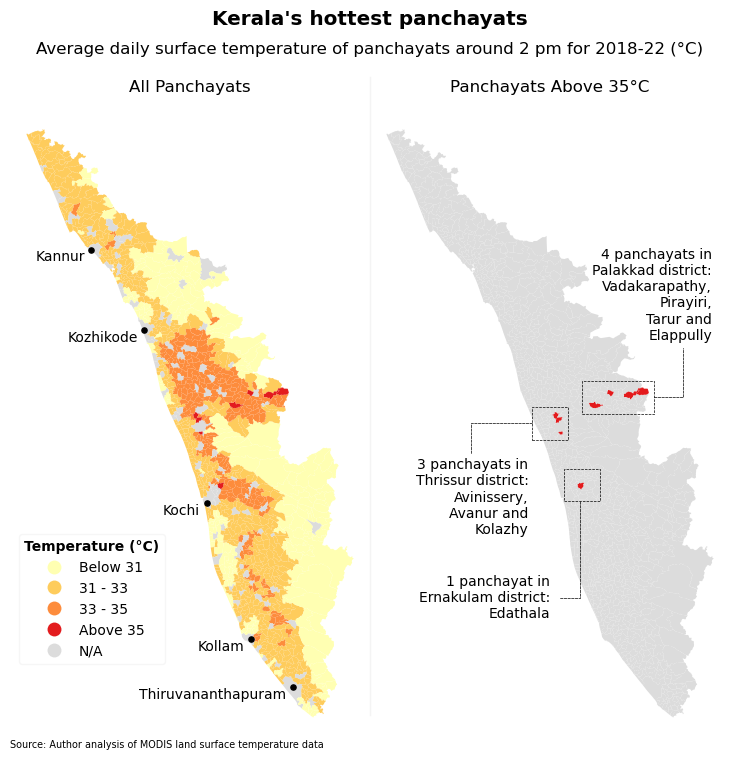

In [17]:
# the code in this cell produces a graphic that shows avg surface temps of all
	# panchayats in the last five years 2018-2022

%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

def get_panch_day_temp_category(row):
	auth_level = row['local_auth']
	day_temp = row['LST_Day_1km_mod_mean_after']

	if auth_level != 'gram_panchayat':
		return 99
	else:
		if day_temp < (31 + 273.15):
			return 1
		elif day_temp < (33 + 273.15):
			return 2
		elif day_temp < (35 + 273.15):
			return 3
		else:
			return 4

diff_mean_zonal_temp_df['day_temp_category'] =\
	diff_mean_zonal_temp_df.apply(lambda row: get_panch_day_temp_category(row), axis=1)

# colours from colorbrewer
colour_list_cb = ['#ffffb2','#fecc5c','#fd8d3c','#e31a1c','#DCDCDC']

cmap_name = 'cb_list_1'
cmap_cb = LinearSegmentedColormap.from_list(cmap_name, colour_list_cb)

# kerala_asp_rat = get_bbox_aspect_ratio(merged.total_bounds) # height/width
# width = 6
# height = width * kerala_asp_rat

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(8, 8)

plt.subplots_adjust(left=0.05,
					bottom=0.025,
					right=0.95,
					top=0.9,
					wspace=0,
					hspace=0)

new_labels = [ 'Below 31', '31 - 33', '33 - 35', 'Above 35','N/A']

diff_mean_zonal_temp_df.plot(
					ax=ax1,
					column='day_temp_category',
					cmap=cmap_cb, 
					categorical=True,
					legend = True,
					legend_kwds={
								# 'labels': new_labels,
								# 'borderpad': 0.75,
								'title': 'Temperature (°C)',
								'title_fontproperties':{
										'weight': 'bold',
										},
								# 'framealpha': 0,
								},
							)

leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.05, -0.06, 0.4, 0.4), transform=ax1.transAxes)
for index_label, txt_label in enumerate(leg.texts):
	txt_label.set_text(new_labels[index_label])

frame = leg.get_frame()
frame.set_linewidth(1)
frame.set_edgecolor('#f4f4f4')

plot_suptitle = "Kerala's hottest panchayats"
plt.suptitle(plot_suptitle, fontweight='bold', fontsize='x-large')

plot_subtitle = "Average daily surface temperature of panchayats around 2 pm for 2018-22 (°C)"
# plt.title(label = plot_subtitle, pad=0, y=0.8)
plt.text(0.5, 0.925, plot_subtitle, transform=fig.transFigure,
		horizontalalignment='center', fontsize='large')

ax1.set_title('All Panchayats', wrap=True)
ax1.set_axis_off()
# ax.margins(0) # dont use this, makes things really tight

# ax1.add_patch(Rectangle((0.5, 0.5), width=0.3, height=0.1, facecolor = 'none', 
# 			edgecolor = 'black', linewidth = 1, transform = ax1.transAxes))
# ax1.annotate("Dummy Text", xy=(0.8, 0.55), xycoords='axes fraction', 
# 			xytext=(1.2, 0.55), textcoords='axes fraction',
# 			arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)


###########################################################

def get_above_35_boolean(row):
	auth_level = row['local_auth']
	day_temp = row['LST_Day_1km_mod_mean_after']

	if auth_level != 'gram_panchayat':
		return 0
	else:
		if day_temp < (35 + 273.15):
			return 0
		else:
			return 1

diff_mean_zonal_temp_df['above_35_boolean'] =\
	diff_mean_zonal_temp_df.apply(lambda row: get_above_35_boolean(row), axis=1)

cmap_35_boolean = LinearSegmentedColormap.from_list('cb_list_35_boolean', 
											['#DCDCDC', '#e31a1c',])

diff_mean_zonal_temp_df.plot(
					ax=ax2,
					column='above_35_boolean',
					cmap=cmap_35_boolean, 
					categorical=True,
							)


# PKD rect 
ax2.add_patch(Rectangle((0.59, 0.515), width=0.2, height=0.05, facecolor = 'none', 
			edgecolor = 'black', linewidth = 0.5, transform = ax2.transAxes,
			linestyle='--'))
pkd_text = '4 panchayats in\nPalakkad district:\nVadakarapathy,\nPirayiri,\n' +\
	'Tarur and\nElappully'
ax2.text(0.95, 0.63, pkd_text, transform = ax2.transAxes, fontsize='medium',
		horizontalalignment='right')
pkd_arrow = FancyArrowPatch((0.78, 0.54), (0.87, 0.62), arrowstyle='-',
			linestyle="--",	linewidth = 0.5, color='black', 
			transform = ax2.transAxes,
			connectionstyle="angle,angleA=180,angleB=-90,rad=0",)
ax2.add_patch(pkd_arrow)			

# TCR rect
ax2.add_patch(Rectangle((0.54, 0.38), width=0.1, height=0.05, facecolor = 'none', 
			edgecolor = 'black', linewidth = 0.5, transform = ax2.transAxes,
			linestyle='--'))
tcr_text = '3 panchayats in\nThrissur district:\nAvinissery,\nAvanur and\nKolazhy'
ax2.text(0.44, 0.33, tcr_text, transform = ax2.transAxes, fontsize='medium',
		horizontalalignment='right')
tcr_arrow = FancyArrowPatch((0.28, 0.45), (0.46, 0.5), arrowstyle='-',
			linestyle="--",	linewidth = 0.5, color='black', 
			transform = ax2.transAxes,
			connectionstyle="angle,angleA=-90,angleB=180,rad=0",)
ax2.add_patch(tcr_arrow)


# EKM rect
ax2.add_patch(Rectangle((0.45, 0.475), width=0.1, height=0.05, facecolor = 'none', 
			edgecolor = 'black', linewidth = 0.5, transform = ax2.transAxes,
			linestyle='--'))
ekm_text = '1 panchayat in\nErnakulam district:\nEdathala'
ax2.text(0.5, 0.2, ekm_text, transform = ax2.transAxes, fontsize='medium',
		horizontalalignment='right')
ekm_arrow = FancyArrowPatch((0.52, 0.23), (0.5825, 0.385), arrowstyle='-',
			linestyle="--",	linewidth = 0.5, color='black', 
			transform = ax2.transAxes,
			connectionstyle="angle,angleA=180,angleB=-90,rad=0",)
ax2.add_patch(ekm_arrow)


ax2.set_title('Panchayats Above 35°C', wrap=True)
ax2.set_axis_off()

ax2.plot([0, 0], [0.05, 1.035], color='#f4f4f4', lw=1,
		transform=ax2.transAxes, clip_on=False)

city_dict = {
			'Kannur':[75.3704, 11.8745],
			'Kozhikode':[75.7804, 11.2588],
			'Kochi':[76.2673, 9.9312],
			'Kollam':[76.6141, 8.8932],
			'Thiruvananthapuram':[76.9366, 8.5241]
			}

for city in city_dict:
	ax1.scatter(city_dict[city][0],city_dict[city][1], s=14, c='#000000')
	ax1.text(city_dict[city][0]-0.05, city_dict[city][1], city, fontsize='medium',
	horizontalalignment='right',verticalalignment='top')

# fig.tight_layout() #pad=0

sources_text = 'Source: Author analysis of MODIS land surface temperature data'
fig.text(0, 0, sources_text, transform=ax1.transAxes,
		horizontalalignment='left', fontsize='x-small')

In [ ]:
# creating IMAGES folder

import os 

if not os.path.isdir('IMAGES'):
    os.makedirs('IMAGES')

In [18]:
fig.savefig('IMAGES/02_hottest_panchayats.png', bbox_inches='tight', dpi=100)

In [20]:
# Taking a look at which panchayats have had surface temperatures at noon 
	# rise by over 1.5 degrees from 2008-2012 to 2018-2022 
	# Vijayapuram panchayat in Kottayam comes first 

diff_mean_zonal_temp_df[
	(diff_mean_zonal_temp_df['LST_Day_1km_mod_mean_diff'] >= 1.5)
	# &(diff_mean_zonal_temp_df['nearest_nonpanchayat_distance_km']>=10)
	& (diff_mean_zonal_temp_df['local_auth']=='gram_panchayat')
	].sort_values(by=['LST_Day_1km_mod_mean_diff'], ascending=False)

admin_leve      local_auth                         name  \
802          8  gram_panchayat  Vijayapuram Gramapanchayath   
797          8  gram_panchayat    Manarcadu Gramapanchayath   
956          8  gram_panchayat  Vilavoorkkal Gramapanchayat   
857          8  gram_panchayat     Mayyanad Grama Panchayat   

                        name_ml   wikidata LSGI_Code            District  \
802    വിജയപുരം ഗ്രാമപഞ്ചായത്ത്  Q31708424    G05072            Kottayam   
797  മണര്‍കാട് ഗ്രാമ പഞ്ചായത്ത്  Q20582342    G05048            Kottayam   
956  വിളവൂർക്കൽ ഗ്രാമപഞ്ചായത്ത്  Q99999071    G01025  Thiruvananthapuram   
857   മയ്യനാട് ഗ്രാമ പഞ്ചായത്ത്  Q13113878    G02053              Kollam   

     Block_QID                   BlockName      DP_QID  \
802  Q16137872      Pallam Block Panchayat  Q100982783   
797  Q13113196     Pambady Block Panchayat  Q100982783   
956  Q20580639       Nemam Block Panchayat  Q100982786   
857  Q13114113  Mughathala Block Panchayat   Q16135247   

                                   DP_Name  generated_id region  \
802            Kottayam District Panchayat           802  South   
797            Kottayam District Panchayat           797  South   
956  Thiruvananthapuram District Panchayat           956  South   
857              Kollam District Panchayat           857  South   

     LST_Day_1km_mod_mean  LST_Night_1km_mod_mean  LST_Day_1km_mod_mean_after  \
802            305.485892              295.235134                  307.190094   
797            305.311243              295.003582                  307.009017   
956            304.219108              295.358392                  305.871601   
857            304.525901              295.975418                  306.048469   

     LST_Night_1km_mod_mean_after  LST_Day_1km_mod_mean_diff  \
802                    295.869333                   1.704202   
797                    295.732504                   1.697774   
956                    296.127640                   1.652493   
857                    296.641278                   1.522568   

     LST_Night_1km_mod_mean_diff  nearest_nonpanchayat_distance_km  \
802                     0.634198                          0.000000   
797                     0.728922                          1.818548   
956                     0.769248                          0.000000   
857                     0.665860                          0.000000   

    nearest_nonpanchayat_name  nearest_nonpanchayat_id  \
802                Ettumanoor                      792   
797                  Kottayam                      805   
956        Thiruvananthapuram                      234   
857                    Kollam                      231   

    nearest_nonpanchayat_auth_level   ids_surrounding_string  \
802                    municipality  792,793,797,800,801,805   
797                    municipality      793,796,798,800,802   
956           municipal_corporation          234,955,958,959   
857           municipal_corporation          231,854,856,858   

                                              geometry  day_temp_category  \
802  MULTIPOLYGON (((76.55654 9.62587, 76.55680 9.6...                  3   
797  MULTIPOLYGON (((76.57267 9.60449, 76.57446 9.6...                  3   
956  MULTIPOLYGON (((77.01947 8.47741, 77.01875 8.4...                  2   
857  MULTIPOLYGON (((76.66371 8.84386, 76.66215 8.8...                  2   

     above_35_boolean  day_temp_DELTA_category  above_1point5_boolean  
802                 0                        4                      1  
797                 0                        4                      1  
956                 0                        4                      1  
857                 0                        4                      1

2023-02-22 11:00:21,076 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Text(0, 0, 'Source: Author analysis of MODIS land surface temperature data')

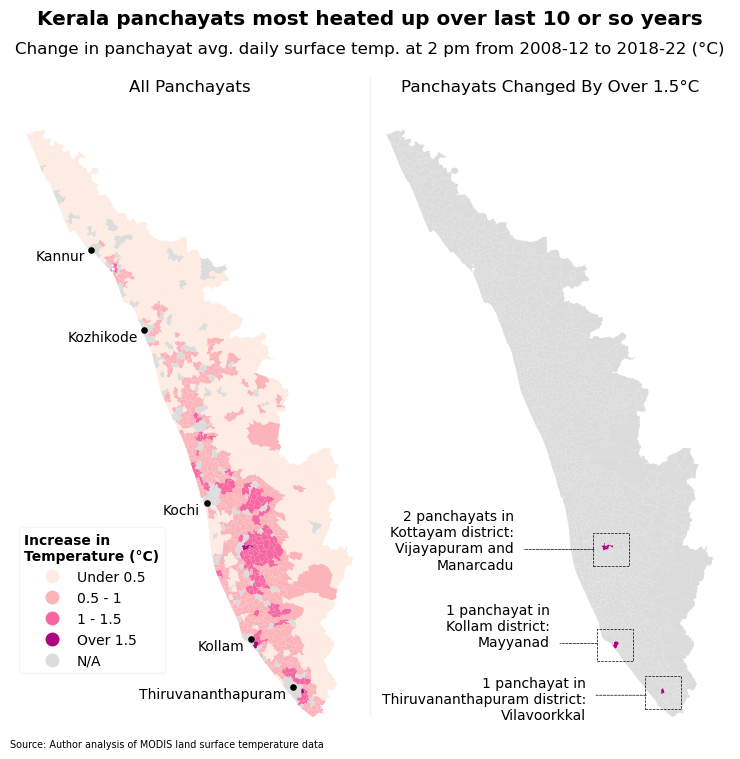

In [22]:
# the code in this cell produces a graphic that pinpoints the rise in temp for
	# all panchayats from 2008-2012 to 2018-2022

%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

def get_panch_day_temp_DELTA_category(row):
	auth_level = row['local_auth']
	day_temp_delta = row['LST_Day_1km_mod_mean_diff']

	if auth_level != 'gram_panchayat':
		return 99
	else:
		if day_temp_delta < 0.5:
			return 1
		elif day_temp_delta < 1:
			return 2
		elif day_temp_delta < 1.5:
			return 3
		else:
			return 4

diff_mean_zonal_temp_df['day_temp_DELTA_category'] =\
	diff_mean_zonal_temp_df.apply(lambda row:\
		 get_panch_day_temp_DELTA_category(row), axis=1)

# colours from colorbrewer
colour_list_cb_delta = ['#feebe2','#fbb4b9','#f768a1','#ae017e','#DCDCDC']

cmap_name_delta = 'cb_list_delta'
cmap_cb_delta = LinearSegmentedColormap.from_list(cmap_name_delta, 
											colour_list_cb_delta)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(8, 8)

plt.subplots_adjust(left=0.05,
					bottom=0.025,
					right=0.95,
					top=0.9,
					wspace=0,
					hspace=0)

new_labels = [ 'Under 0.5', '0.5 - 1', '1 - 1.5', 'Over 1.5','N/A']

diff_mean_zonal_temp_df.plot(
					ax=ax1,
					column='day_temp_DELTA_category',
					cmap=cmap_cb_delta, 
					categorical=True,
					legend = True,
					legend_kwds={
								# 'labels': new_labels,
								# 'borderpad': 0.75,
								'title': 'Increase in\nTemperature (°C)',
								'title_fontproperties':{
										'weight': 'bold',
										},
								# 'framealpha': 0,
								},
							)

leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.05, -0.05, 0.4, 0.4), transform=ax1.transAxes)
for index_label, txt_label in enumerate(leg.texts):
	txt_label.set_text(new_labels[index_label])

frame = leg.get_frame()
frame.set_linewidth(1)
frame.set_edgecolor('#f4f4f4')

plot_suptitle = "Kerala panchayats most heated up over last 10 or so years"
plt.suptitle(plot_suptitle, fontweight='bold', fontsize='x-large')

plot_subtitle = "Change in panchayat avg. daily surface temp. at 2 pm from 2008-12 to 2018-22 (°C)"
# plt.title(label = plot_subtitle, pad=0, y=0.8)
plt.text(0.5, 0.925, plot_subtitle, transform=fig.transFigure,
		horizontalalignment='center', fontsize='large')

ax1.set_title('All Panchayats', wrap=True)
ax1.set_axis_off()
# ax.margins(0) # dont use this, makes things really tight


###########################################################

def get_above_1point5_boolean(row):
	auth_level = row['local_auth']
	day_temp_DELTA = row['LST_Day_1km_mod_mean_diff']

	if auth_level != 'gram_panchayat':
		return 0
	else:
		if day_temp_DELTA < 1.5:
			return 0
		else:
			return 1

diff_mean_zonal_temp_df['above_1point5_boolean'] =\
	diff_mean_zonal_temp_df.apply(lambda row: get_above_1point5_boolean(row), 
	axis=1)

extreme_color = '#ae017e'
cmap_1point5_boolean = LinearSegmentedColormap.from_list(\
	'cb_list_1point5_boolean', ['#DCDCDC', extreme_color])

diff_mean_zonal_temp_df.plot(
					ax=ax2,
					column='above_1point5_boolean',
					cmap=cmap_1point5_boolean, 
					categorical=True,
							)

annotation_dict = {
					'kottayam': {
							'rect_x':0.62,'rect_y':0.28,'rect_width':0.1,
							'text':('2 panchayats in\n''Kottayam district:\n'
									'Vijayapuram and\n''Manarcadu'),
							'text_x':0.4,'text_y':0.275,
							'tail_x':0.63,'tail_y':0.305,
							'head_x':0.42,'head_y':0.305,
							'connectionstyle':"arc3,rad=0."
							},
					'kollam': {
							'rect_x':0.63,'rect_y':0.1325,'rect_width':0.1,
							'text':('1 panchayat in\n''Kollam district:\n'
									'Mayyanad'),
							'text_x':0.5,'text_y':0.155,
							'tail_x':0.64,'tail_y':0.16,
							'head_x':0.52,'head_y':0.16,
							'connectionstyle':"arc3,rad=0."
							},
					'thiruvananthapuram': {
							'rect_x':0.765,'rect_y':0.059,'rect_width':0.1,
							'text':('1 panchayat in\n'
									'Thiruvananthapuram district:\n'
									'Vilavoorkkal'),
							'text_x':0.6,'text_y':0.0425,
							'tail_x':0.775,'tail_y':0.08,
							'head_x':0.62,'head_y':0.08,
							'connectionstyle':"arc3,rad=0."
							},
					}

for district in annotation_dict:

	rect_x = annotation_dict[district]['rect_x']
	rect_y = annotation_dict[district]['rect_y']
	rect_width = annotation_dict[district]['rect_width']
	ax2.add_patch(Rectangle((rect_x, rect_y), width=rect_width, height=0.05, 
				facecolor = 'none', edgecolor = 'black', linewidth = 0.5, 
				transform = ax2.transAxes, linestyle='--'))	

	dist_text = annotation_dict[district]['text']
	dist_text_x =  annotation_dict[district]['text_x']
	dist_text_y = annotation_dict[district]['text_y']
	ax2.text(dist_text_x, dist_text_y, dist_text, transform = ax2.transAxes, fontsize='medium', horizontalalignment='right')

	tail_x = annotation_dict[district]['tail_x']
	tail_y = annotation_dict[district]['tail_y']
	head_x = annotation_dict[district]['head_x']
	head_y = annotation_dict[district]['head_y']
	connectionstyle = annotation_dict[district]['connectionstyle']
	dist_arrow = FancyArrowPatch((tail_x, tail_y), (head_x, head_y), arrowstyle='-',
				linestyle="--",	linewidth = 0.5, color='black', 
				transform = ax2.transAxes,
				connectionstyle=connectionstyle)
	ax2.add_patch(dist_arrow)

ax2.set_title('Panchayats Changed By Over 1.5°C')
ax2.set_axis_off()

ax2.plot([0, 0], [0.05, 1.035], color='#f4f4f4', lw=1,
		transform=ax2.transAxes, clip_on=False)

city_dict = {
			'Kannur':[75.3704, 11.8745],
			'Kozhikode':[75.7804, 11.2588],
			'Kochi':[76.2673, 9.9312],
			'Kollam':[76.6141, 8.8932],
			'Thiruvananthapuram':[76.9366, 8.5241]
			}

for city in city_dict:
	ax1.scatter(city_dict[city][0],city_dict[city][1], s=14, c='#000000')
	ax1.text(city_dict[city][0]-0.05, city_dict[city][1], city, fontsize='medium',
	horizontalalignment='right',verticalalignment='top')

sources_text = 'Source: Author analysis of MODIS land surface temperature data'
fig.text(0, 0, sources_text, transform=ax1.transAxes,
		horizontalalignment='left', fontsize='x-small')

In [23]:
fig.savefig('IMAGES/03_hottest_panchayats_DELTA.png', bbox_inches='tight', dpi=100)

In [74]:
# this cell calculates what % of a district's panchayats have risen in 
	# surface temp by at least 0.5 degrees from 2008-12 to 2018-22

dist_affected_num = diff_mean_zonal_temp_df[
	(diff_mean_zonal_temp_df['LST_Day_1km_mod_mean_diff']>=0.5)
	& (diff_mean_zonal_temp_df['local_auth']=='gram_panchayat')
	].groupby('District').size().reset_index(name='affected')

dist_total_num = diff_mean_zonal_temp_df[
	(diff_mean_zonal_temp_df['local_auth']=='gram_panchayat')
	].groupby('District').size().reset_index(name='total')

dist_combined = pd.merge(dist_total_num, dist_affected_num, 
													on='District', how='outer')

dist_combined['affected'].fillna(0, inplace=True)

dist_combined['percent'] =\
	 round(100*dist_combined['affected']/dist_combined['total'])

dist_combined.sort_values('percent', ascending=False, inplace=True)

dist_combined['affected'] = dist_combined['affected'].astype('int')
dist_combined['percent'] = dist_combined['percent'].astype('int')

dist_combined

District  total  affected  percent
10      Pathanamthitta     53        50       94
6             Kottayam     71        65       92
1            Ernakulam     83        75       90
5               Kollam     67        60       90
11  Thiruvananthapuram     73        56       77
12            Thrissur     86        63       73
0            Alappuzha     73        45       62
8           Malappuram     94        31       33
9             Palakkad     88        28       32
2               Idukki     51        14       27
7            Kozhikode     70        18       26
3               Kannur     71         9       13
4            Kasaragod     38         0        0
13             Wayanad     23         0        0

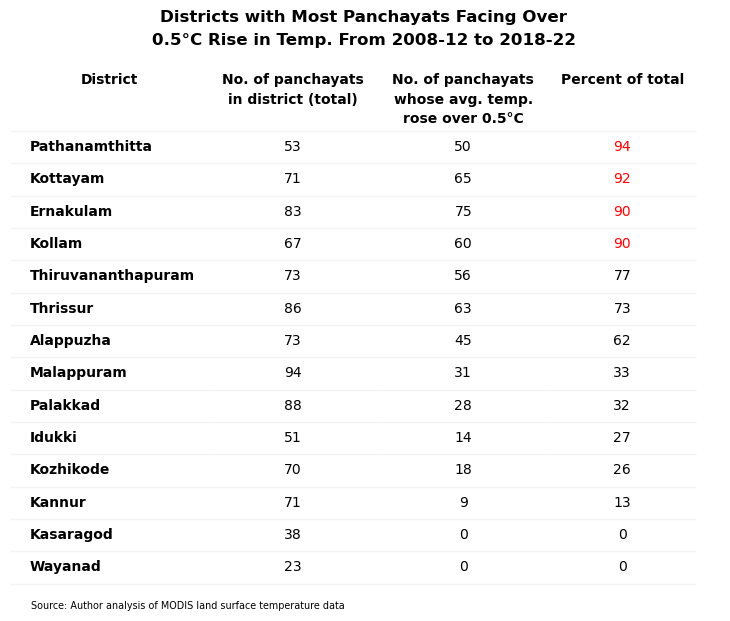

In [75]:
# this cell makes a table showing what % of a district's panchayats have risen in 
	# surface temp by at least 0.5 degrees from 2008-12 to 2018-22

# %config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(figsize=(0.5,6)) #figsize=(8,8)

# hide axes
# fig.patch.set_visible(False)
ax.set_axis_off()
# ax.set_axis_tight()


tb = ax.table(cellText=dist_combined.values, 
		colLabels=['District', 'No. of panchayats\nin district (total)', 
			'No. of panchayats\nwhose avg. temp.\nrose over 0.5°C',
			'Percent of total'], 
		loc='left',
		edges='B',
		# x=0,
		# fontsize=12,
		)
tb.auto_set_font_size(False)


title_text='Districts with Most Panchayats Facing Over\n' +\
	'0.5°C Rise in Temp. From 2008-12 to 2018-22'
#
ax.text(s=title_text,
	horizontalalignment='center', fontweight='bold',
	x=-14,y=1.05,
	linespacing=1.7, transform=ax.transAxes,
	 fontsize='large'
	)


# header cells in first row
for j in range(4):
	tb[(0, j)].get_text().set_fontweight('bold')
	tb[(0, j)].get_text().set_linespacing(1.5)
	tb[(0, j)].get_text().set_verticalalignment('top')
	# tb[(0, j)].get_text().set_position([0,0])
	tb[(0, j)].set_height(0.25)
	# tb[(0, j)].set_padding(0)
	tb[(0, j)].set_edgecolor('#f4f4f4')
	# tb[(0, j)].set_y(1)

# cells in district column
for i in range(1, len(dist_combined)+1):
	# tb[(i, 0)].get_text().set_fontsize('medium')
	tb[(i, 0)].get_text().set_fontweight('bold')
	tb[(i, 0)].get_text().set_horizontalalignment('left')
	tb[(i, 0)].set_height(0.07)
	tb[(i, 0)].set_edgecolor('#f4f4f4')
	# tb[(0, i)].set(height=1)

# cells in other columns
for i in range(1, len(dist_combined)+1):
	for j in [1,2,3]:
		# tb[(i, j)].get_text().set_fontsize('medium')
		tb[(i, j)].get_text().set_horizontalalignment('center')
		tb[(i, j)].set_height(0.07)
		tb[(i, j)].set_edgecolor('#f4f4f4')

# cells in last column
for i in range(1, len(dist_combined)+1):
	# tb[(i, 3)].get_text().set_fontweight('bold')
	val = int(tb[(i, 3)].get_text().get_text())
	if val >= 90: tb[(i, 3)].get_text().set_color('red')


tb.auto_set_column_width(col=range(4))
# fig.tight_layout()

sources_text = 'Source: Author analysis of MODIS land surface temperature data'
ax.text(-28, -0.17, sources_text, transform=ax.transAxes,
		horizontalalignment='left', fontsize='x-small')

plt.subplots_adjust(right = 0.6)

plt.show()

In [76]:
fig.savefig('IMAGES/04_districts_most_panchayats_heated_up.png', bbox_inches='tight',
	dpi=100)

In [ ]:
# the cells below all define functions that help us request data from microsoft 
	# planetary computer for different satellites and for different uses 
	# Some for example will be about showing a panchayat in true color 

In [34]:
# get bounding box for a panchayat. Helps limit data that needs to be requested 

def get_bbox(panchayat_id):
	shapely_polygon = unmerged[unmerged['generated_id']==panchayat_id]\
															['geometry'].iloc[0]
	bbox = shapely_polygon.bounds

	return bbox

In [35]:
# gets true color image from sentinel satellite 
	# this is the highest resolution openly available satellite data 
	
def get_image_sentinel(datetime_string, bbox, sorted_rank, crs, resolution):
	
	catalog = pystac_client.Client.open(
	"https://planetarycomputer.microsoft.com/api/stac/v1",
	modifier=planetary_computer.sign_inplace,
	)
	
	search = catalog.search(
		bbox=bbox,
		datetime= datetime_string,
		collections=["sentinel-2-l2a"],
		query={"eo:cloud_cover": {"lte": 5}},
	)

	search_results = search.item_collection()

	# selected_item = min(search_results, 
	# 						key=lambda item: eo.ext(item).cloud_cover)

	sorted_list = sorted(search_results, 
							key=lambda item: eo.ext(item).cloud_cover)
	selected_item = sorted_list[sorted_rank]

	date_selection = selected_item.datetime.strftime('%Y-%m-%d')
	print('date of sentinel selection is ' + date_selection)

	data = (
		odc.stac.load(
			items = [selected_item],
			bands=["red", "green", "blue"],
			crs=crs, # such as "EPSG:7781","EPSG:32643", "EPSG:4326"
			# chunksize=4096,
			resolution=resolution, #if metres use 10, if degrees use 0.00009009
			bbox=bbox,
			)
	)

	data_sq = data.squeeze('time', drop=True)

	return data_sq

In [36]:
# For old imagery, we need to depend on a satellite called landsat 
	# This function creates a grid of images for different days, 
	# so that we can choose one we like and download just that 

def create_image_grid(datetime_string, bbox, max_cloud):
	catalog = pystac_client.Client.open(
	"https://planetarycomputer.microsoft.com/api/stac/v1",
	modifier=planetary_computer.sign_inplace,
	)

	search = catalog.search(
		bbox = bbox,
		datetime= datetime_string,
		collections=["landsat-c2-l2"],
		query={"eo:cloud_cover": {"lte": max_cloud},
				},
		)

	search_results = search.item_collection()

	data = (
		odc.stac.load(
			items = search_results,
			bands=["red", "green", "blue"],
			crs="EPSG:32643", #another option is 7781 
			# chunksize=4096,
			resolution=30,
			bbox=bbox,
			)
			)

	images = [ms.true_color(r=x[1]['red'], g=x[1]['green'], b=x[1]['blue'])\
												for x in data.groupby('time')]
	images_concat = xr.concat(images, dim="time")

	g = images_concat.plot.imshow(x="x", y="y", rgb="band", col="time", 
						col_wrap=3,
						#  figsize=(10, 10)
						 ) # size=2, aspect='auto' ?

	date_list = [x.astype(str)[:10] for x in data['time'].values]
	for ax, date  in zip(g.axes.flat, date_list):
		ax.set_axis_off()
		ax.set_title(date)

	plt.tight_layout()

In [37]:
# # Ended up not using this function, keeping it here for posterity. 

# # There is a way to programatically download landsat data from USGS using 
# 	# their M2M api, but didn't want to learn yet another API. 
# 	# Here I just used urls printed with this function and downloaded files 
# 	# through my browser, you might need to be registered at 
# 	# https://ers.cr.usgs.gov/register to do that.
# 	# If you want to do it through code, you'll have to register and sign up 
# 	# for the M2M api at https://m2m.cr.usgs.gov/
# 	# Tutorial for how to use M2M api at https://code.usgs.gov/lcmap/1_lcmap_access/-/blob/main/EE_M2M_API_LCMAP_Access.ipynb

# def get_files_landsat(datetime_string, bbox, sat_name, max_cloud, panchayat_name, 
# 																	sorted_rank):

# 	catalog_lsat =\
# 		pystac_client.Client.open(f'https://landsatlook.usgs.gov/stac-server')

# 	search_lsat = catalog_lsat.search(
# 		bbox=bbox,
# 		datetime= datetime_string,
# 		collections=['landsat-c2l1'], 
# 		query={"eo:cloud_cover": {"lte": max_cloud},
# 				'platform':{'eq': sat_name} # After 2013, exclude LANDSAT_7
# 		},
# 		)

# 	search_lsat_results = search_lsat.item_collection()

# 	# selected_item = min(search_lsat_results, 
# 	# 						key=lambda item: eo.ext(item).cloud_cover)

# 	sorted_list = sorted(search_lsat_results, 
# 							key=lambda item: eo.ext(item).cloud_cover)
# 	selected_item = sorted_list[sorted_rank]

# 	# making a directory on jupyter hub to upload files to 
# 	folder_name = selected_item.datetime.strftime('%b_%d_%Y')
# 	print(folder_name)
# 	folder_path = panchayat_name + '/' + folder_name
# 	if not os.path.isdir(folder_path):
# 		os.makedirs(folder_path)

# 	filename_dict = {
# 				'red': None, 
# 				'green': None, 
# 				'blue': None, 
# 				'pan': None, 
# 				# 'nir08': None, 
# 				}

# 	for band in filename_dict:
# 		href = selected_item.assets[band].href
# 		print(href)
# 		file_name = href.split('/')[-1]
# 		filename_dict[band] = file_name

# 	return filename_dict

In [38]:
# # another function that I ended up not needing, keeping for posterity 

# 	# what this function does is take imagery for landsat and sharpens it 
# 	# wasn't able to make it work properly

# def get_pansharpened_landsat(filename_dict, panchayat_name, folder_name, bbox):
	
# 	folder_path = panchayat_name + '/' + folder_name

# 	for band in filename_dict:
# 		file_name = filename_dict[band]
# 		dset = rioxarray.open_rasterio((folder_path + '/' + file_name))
# 		dset_cropped = dset.rio.clip_box(
# 										minx=bbox[0],
# 										miny=bbox[1],
# 										maxx=bbox[2],
# 										maxy=bbox[3],
# 										crs="EPSG:4326",  # this is CRS of bbox
# 										)

# 		file_name_cropped = folder_path + '/' + band + '_cropped.TIF'
# 		dset_cropped.rio.to_raster(file_name_cropped)

# 	pansharp_file_path = folder_path + '/' + 'pansharpened.nc'

# 	gdal_pansharpen(
# 		pan_name= folder_path + '/' + 'pan' + '_cropped.TIF',
# 		spectral_names=[folder_path + '/' + 'red' + '_cropped.TIF',
# 						folder_path + '/' + 'green' + '_cropped.TIF',
# 						folder_path + '/' + 'blue' + '_cropped.TIF'
# 						],
# 		# weights = [0.2, 0.3267, 0.14, 0.3333],
# 		# weights = [0.15, 0.45, 0.35, 0.05],
# 		# weights = [1/3, 1/4, 1/12, 1/3],
# 		dst_filename = pansharp_file_path,
# 		resampling= 'bilinear',
# 		nodata_value=0,
# 		# argv=['-q']
# 		)

# 	xds = rioxarray.open_rasterio(pansharp_file_path)
# 	os.remove(pansharp_file_path)

# 	xds_sq = xds.squeeze()

# 	return xds_sq

In [39]:
# what this does is take old imagery from landsat satellite and upsamples it 
	# A kind of fake improvement in resolution. 

# code from https://spatial-dev.guru/2022/09/24/upsample-and-downsample-raster-in-python-using-rioxarray/

def upsample_mpc_result(datetime_string, bbox, max_cloud, sorted_rank, crs, 
																	resolution):

	catalog = pystac_client.Client.open(
	"https://planetarycomputer.microsoft.com/api/stac/v1",
	modifier=planetary_computer.sign_inplace,
	)

	search = catalog.search(
		bbox = bbox,
		datetime= datetime_string,
		collections=["landsat-c2-l2"],
		query={"eo:cloud_cover": {"lte": max_cloud},
			# 'platform':{'eq':'landsat-8'} #LANDSAT_8 in caps for c2-l1 collctn
				},
		)

	search_results = search.item_collection()

	sorted_list = sorted(search_results, 
							key=lambda item: eo.ext(item).cloud_cover)
	selected_item = sorted_list[sorted_rank]

	data = (
		odc.stac.load(
			items = [selected_item],
			bands=["red", "green", "blue"],
			crs=crs, #for projection in metres, "EPSG:32643" or "EPSG:7781"
			# chunksize=4096,
			resolution=resolution, #use 30 for metres proj, 0.00027027 for 4326 
			bbox=bbox,
			)
			)

	# DO I NEED TO SQUEEZE ANY DIMENSIONT OUT HERE?
	data_sq = data.squeeze('time')

	merged_array = data_sq.to_array()

	upscale_factor = 2

	new_width = merged_array.rio.width * upscale_factor
	new_height = merged_array.rio.height * upscale_factor

	upsampled = merged_array.rio.reproject(data.rio.crs, 
								shape=(int(new_height), int(new_width)), 
								resampling=Resampling.bilinear)
	
	return upsampled

In [40]:
# this functions get the height and width of a bounding box in kilometres 

def get_bbox_high_wid(bbox):
	south_west = (bbox[1],bbox[0])
	south_east = (bbox[1],bbox[2])
	north_east = (bbox[3],bbox[2])
	height = geopy_dist(south_east, north_east).kilometers
	width = geopy_dist(south_west, south_east).kilometers
	height = round(height)
	width = round(width)
	print('bbox is {} km high and {} km wide'.format(str(height),str(width)))

In [41]:
# This function gets land use land cover (LULC) data from the central 
	# government's bhuvan service . There's some processing involved 
	# as bhuvan's API just returns an image. This function takes the image 
	# and gets out actual data values -- LULC classes -- that we can use


# the lulc class codes will be in the 'class_new' band. What those codes represent can be seen in the url below
	# https://bhuvan-vec2.nrsc.gov.in/bhuvan/wms?REQUEST=GetLegendGraphic&VERSION=1.0.0&FORMAT=application/json&WIDTH=20&HEIGHT=20&LAYER=lulc:KL_LULC50K_1112
	# use the 'red_new', 'green_new' and 'blue_new' bands to visualise the data


def download_lulc_data(state, bbox, period, save_path):

	'''
	This function gets 1:50,000 or 25m resolution land use/land cover imagery \n
	from bhuvan's wms service, estimates the underlying data, and \n
	saves that data as a netcdf file.

	Parameters:
	state -- location of area of interest. Use 2-letter codes like KL for Kerala
	bbox -- bounding box for area of interest: [min_lon,min_lat,max_lon,max_lat] 
	period -- 3 options are '2005-06', '2011-12' and '2015-16'
	save_path -- where netcdf will be saved 
	
	Returns the data as an xarray dataset
	'''

	wms_url = 'https://bhuvan-vec2.nrsc.gov.in/bhuvan/wms'

	# estimating how many 25m pixels high and wide the area is 
	south_west = (bbox[1],bbox[0])
	south_east = (bbox[1],bbox[2])
	north_east = (bbox[3],bbox[2])
	height = round(geopy_dist(south_east, north_east).meters/25)
	width = round(geopy_dist(south_west, south_east).meters/25)
	
	bbox_string = ','.join([str(x) for x in bbox])

	# querying bhuvan wms with specific parameters
	if period == '2005-06':
		layer_name = 'lulc:' + state + '_LULC50K_0506'
		style_name = layer_name
	elif period == '2011-12':
		layer_name = 'lulc:' + state + '_LULC50K_1112'
		style_name = 'lulc:LULC50K_1112_NEW'
	elif period == '2015-16':
		layer_name = 'lulc:' + state + '_LULC50K_1516'
		style_name = 'lulc:LULC50K_1516_NEW'
	
	params_main = {
		'REQUEST': 'GetMap',
		'LAYERS': layer_name,
		'STYLES': style_name,
		'CRS': 'EPSG:4326',
		'BBOX': bbox_string,
		'WIDTH': width, 
		'HEIGHT': height,
		'FORMAT': 'image/geotiff', 
		}
	response_main = requests.get(wms_url, params=params_main)

	# converting response to xarray dataset that's easier to work with 
	img_darray = rioxarray.open_rasterio(MemoryFile(response_main.content)\
				.open(driver='GTiff'))
	img_dset = img_darray.to_dataset(dim='band')
	img_dset = img_dset.rename_vars({1:'red', 2:'green', 3:'blue'})


	# getting legend json that allows us to estimate underlying data
	params_legend = {
	'REQUEST': 'GetLegendGraphic',
	'LAYER': layer_name,
	'STYLE': style_name,
	'FORMAT': 'application/json',
				}
	response_legend = requests.get(wms_url, params=params_legend)
	legend_dict = json.loads(response_legend.content)

	# converting legend json into a simpler dict
	legend_dict_simple = {}
	for rule in legend_dict['Legend'][0]['rules']:
		bhuvan_webcode = int(rule['name'])
		bhuvan_class = rule['title']
		bhuvan_color_hex = rule['symbolizers'][0]['Polygon']['fill']
		bhuvan_color_rgb =\
			tuple(int(bhuvan_color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))	
		legend_dict_simple[bhuvan_color_rgb] = {} # rgb tuples are dict keys here 
		legend_dict_simple[bhuvan_color_rgb]['bhuvan_webcode'] = bhuvan_webcode
		legend_dict_simple[bhuvan_color_rgb]['bhuvan_class'] = bhuvan_class

	# adding explicit 'no data' class to dict, not there in bhuvan classes
	legend_dict_simple[(255,255,255)] =\
		{'bhuvan_webcode':99, 'bhuvan_class':'No Data'}

	# converting colors from rgb colorspace to cie colorspace 
		# conversion necessary to determine closest color in legend json 
	palette_colors_rgb = tuple(legend_dict_simple.keys())
	palette_colors_srgb = [sRGBColor(x[0]/255, x[1]/255, x[2]/255) \
				for x in palette_colors_rgb]
	palette_colors_lab = [convert_color(x, LabColor) for x in palette_colors_srgb]

	# defining function to find closest color in legend json 
	def get_closest_palette_entry(red_val, green_val, blue_val):

		val_tuple = (red_val, green_val, blue_val)

		if val_tuple in palette_colors_rgb:
			closest_palette_rgb_tuple = val_tuple
		elif ((red_val == green_val == blue_val) and (red_val != 225)):
			closest_palette_rgb_tuple = (255,255,255)
		else:
			rgb_tuple_srgb = sRGBColor(val_tuple[0]/255, val_tuple[1]/255, 
									val_tuple[2]/255)
			rgb_tuple_lab = convert_color(rgb_tuple_srgb, LabColor)
			dist_list =\
				[delta_e_cie2000(rgb_tuple_lab, x) for x in palette_colors_lab]
			min_pos = dist_list.index(min(dist_list))
			closest_palette_rgb_tuple = palette_colors_rgb[min_pos]

		closest_bhuvan_webcode =\
			legend_dict_simple[closest_palette_rgb_tuple]['bhuvan_webcode']

		return closest_palette_rgb_tuple[0], closest_palette_rgb_tuple[1],\
				closest_palette_rgb_tuple[2], closest_bhuvan_webcode

	# applying function to every pixel
	new_ufunc = np.frompyfunc(get_closest_palette_entry,3,4)
	closest_palette_entries = new_ufunc(img_dset['red'], img_dset['green'], 
						img_dset['blue'])

	# putting r,g,b values and estimated landuse/landcover class in dataset 
		# as new variables 
	img_dset['red_new'] = closest_palette_entries[0]
	img_dset['green_new'] = closest_palette_entries[1]
	img_dset['blue_new'] = closest_palette_entries[2]
	img_dset['class_new'] = closest_palette_entries[3]

	img_dset  = img_dset.astype('uint8')

	esri_lulc_code_dict = {
		1:{'esri_class_code':7,'esri_class_name':'Built area'},
		2:{'esri_class_code':7,'esri_class_name':'Built area'},
		3:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		4:{'esri_class_code':5,'esri_class_name':'Crops'},
		5:{'esri_class_code':5,'esri_class_name':'Crops'},
		6:{'esri_class_code':5,'esri_class_name':'Crops'},
		7:{'esri_class_code':5,'esri_class_name':'Crops'},
		8:{'esri_class_code':2,'esri_class_name':'Trees'},
		9:{'esri_class_code':2,'esri_class_name':'Trees'},
		10:{'esri_class_code':2,'esri_class_name':'Trees'},
		11:{'esri_class_code':11,'esri_class_name':'Rangeland'},
		12:{'esri_class_code':4,'esri_class_name':'Flooded vegetation'},
		13:{'esri_class_code':11,'esri_class_name':'Rangeland'},
		14:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		15:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		16:{'esri_class_code':11,'esri_class_name':'Rangeland'},
		17:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		18:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		19:{'esri_class_code':8,'esri_class_name':'Bare ground'},
		20:{'esri_class_code':1,'esri_class_name':'Water'},
		21:{'esri_class_code':1,'esri_class_name':'Water'},
		22:{'esri_class_code':1,'esri_class_name':'Water'},
		23:{'esri_class_code':1,'esri_class_name':'Water'},
		24:{'esri_class_code':9,'esri_class_name':'Snow/ice'},
		99:{'esri_class_code':0,'esri_class_name':'No Data'},
		}

	def get_esri_lulc_code(x):
		esri_lulc_code = esri_lulc_code_dict[x]['esri_class_code']
		return esri_lulc_code
	get_esri_lulc_code_ufunc = np.frompyfunc(get_esri_lulc_code,1,1)

	img_dset['class_new_esri'] =\
		get_esri_lulc_code_ufunc(img_dset['class_new'])
	img_dset['class_new_esri']  =\
		img_dset['class_new_esri'].astype('uint8')

	img_dset.to_netcdf(save_path)
	
	return img_dset
	
# open saved netcdf with xarray_dset = xr.open_dataset('kl_2011_12_lulc.nc', decode_coords='all')

In [42]:
# code from https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class#Example-Notebook

# this function gets LULC data for recent years from the ESRI LULC dataset on 
	# microsoft's planetary computer 

def get_lulc_data_mpc(bbox, year):

	'''
	year can be anything from 2017 to 2021
	'''

	stac = pystac_client.Client.open(
		"https://planetarycomputer.microsoft.com/api/stac/v1",
		modifier=planetary_computer.sign_inplace,
	)

	datetime_string = str(year) + '-01-02/' + str(year) + '-12-31'

	search = stac.search(
		bbox=bbox,
		datetime=datetime_string,
		collections=['io-lulc-9-class'],
			)

	search_results = search.item_collection()

	# line below for getting some metadata later on 
	item = search_results[0]

	# Create a single Dataset from multiple results with the corresponding
	# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
	# matches our data, since stackstac will use float64 by default.
	data = (
		odc.stac.load(
			items=search_results,
			dtype='ubyte',
			bbox=bbox,
			crs = "EPSG:4326",
			resolution = 0.00009009,
			)
		.assign_coords(
			time=pd.to_datetime([item.properties["start_datetime"]\
									for item in search_results])
			.tz_convert(None)
			.to_numpy()
			)
		.sortby("time")
		)

	data_sq = data.squeeze().compute()

	collection = stac.get_collection("io-lulc-9-class")
	ia = ItemAssetsExtension.ext(collection)

	x = ia.item_assets["data"]
	class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
	values_to_classes = {v: k for k, v in class_names.items()}
	class_count = len(class_names)

	with rasterio.open(item.assets["data"].href) as src:
		colormap_def = src.colormap(1)  # get metadata colormap for band 1
		colormap = [
		np.array(colormap_def[i])/255 for i in range(max(class_names.values())+1)
		]

	cmap = ListedColormap(colormap)

	return data_sq, cmap, values_to_classes

In [43]:
# the code in the cells below are all abut visualing Vadakarapathy panchayat 
	# using different forms of satellite data and producing a graphic 
	# combining all those smaller ones 

	# there are three sections to the graphic 
		# one show vadakarapathy and subsets of its panchayat area that are hottest 
		# one shows vadakarpathy in true color 
		# last shows panchayat and how land on panchayat is used 

In [44]:
panchayat_id = 471 #generated id for Vadakarapathy panchayat in palakkad dist
bbox_panchayat = get_bbox(panchayat_id)

In [45]:
# 1 sq km areas inside vadakarpathy panchayat that are hottest 

# data for ax1

orig_2018_2022_ds =\
	rioxarray.open_rasterio('kerala_2018_2022_whole_calendar_years_4326.nc')
orig_crs = orig_2018_2022_ds.rio.crs

data_2018_2022 = xr.open_dataset('jan2018_dec2022_scaled.nc', decode_coords="all")
data_2018_2022.rio.write_crs(orig_crs, inplace=True)

data_2018_2022 = data_2018_2022.drop_vars(['LST_Night_1km_mod'])
data_2018_2022_cropped = data_2018_2022.rio.clip_box(
										minx=bbox_panchayat[0],
										miny=bbox_panchayat[1],
										maxx=bbox_panchayat[2],
										maxy=bbox_panchayat[3],
										crs="EPSG:4326",  # this is CRS of bbox
										)

data_2018_2022_pixel_mean = data_2018_2022_cropped.mean(dim="time", 
										skipna=True, keep_attrs=True).compute()

In [46]:
# vadakarapthy in true color 
# data for ax2

datetime_string = '2022-01-01/2022-12-31'
bbox = bbox_panchayat
sorted_rank = 0

ds_after_4326 = get_image_sentinel(datetime_string, bbox, sorted_rank, "EPSG:4326", 
0.00009009)
ds_after_4326 = ds_after_4326.rename({'longitude':'x','latitude':'y'})

# can also do np.dstack on r,g,b channels 
image_after_4326 = ms.true_color(r = ds_after_4326['red'],
							g = ds_after_4326['green'],
							b = ds_after_4326['blue']
							)

date of sentinel selection is 2022-03-14


In [47]:
# lulc data for vadakarpathy 
# data for ax3

data_lulc_after, cmap_lulc, values_to_classes =\
	get_lulc_data_mpc(bbox_panchayat, 2021)

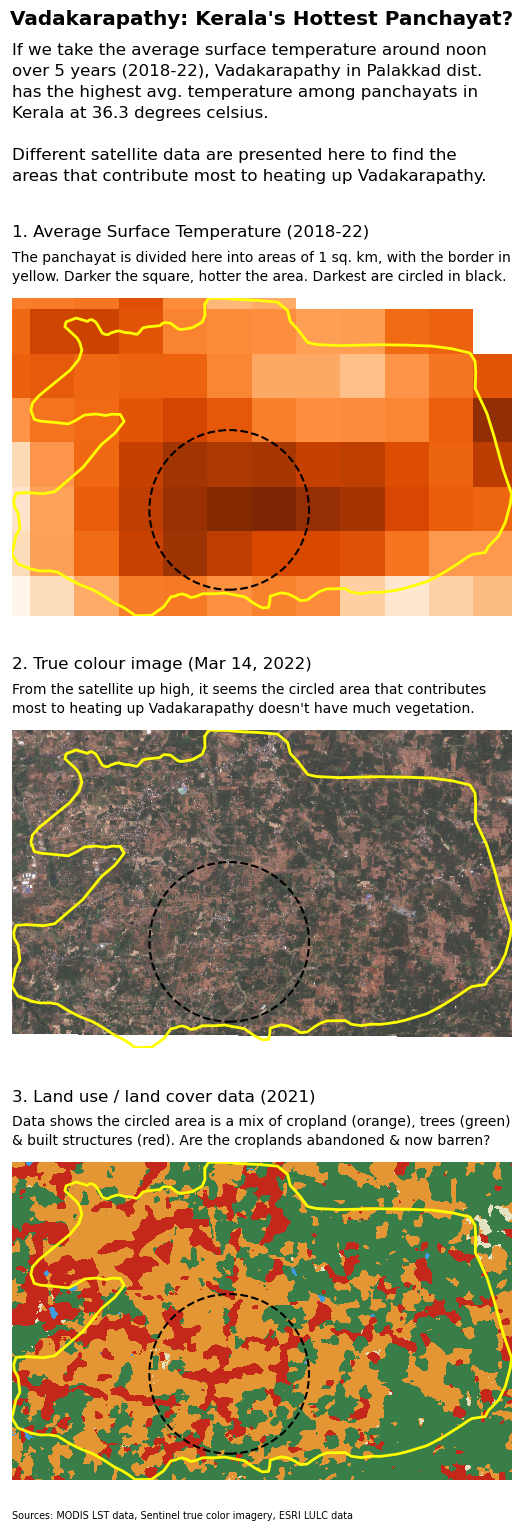

In [54]:
# produces graphic that visualises Vadakarapathy panchayat 
	# using different forms of satellite data

%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

fig, (ax1,ax2,ax3) =\
	plt.subplots(nrows=3, ncols=1, sharex='col') 

fig.set_size_inches(5, 18)

sup_title =\
	"Vadakarapathy: Kerala's Hottest Panchayat?"

plt.text(0.4, 0.93, sup_title, transform=fig.transFigure,
		horizontalalignment='center', fontsize='x-large', fontweight='bold')

#####

intro_text = '\n'.join((
	"If we take the average surface temperature around noon",
	"over 5 years (2018-22), Vadakarapathy in Palakkad dist.",
	"has the highest avg. temperature among panchayats in",
	"Kerala at 36.3 degrees celsius.",
	"",
	'Different satellite data are presented here to find the',
	'areas that contribute most to heating up Vadakarapathy.',
	))

fig.text(-0.1, 0.92, intro_text, transform=fig.transFigure,
		horizontalalignment='left', fontsize='large',linespacing=1.5,
		verticalalignment='top')

#### ax1 -- avg surface temp around noon in 2022

pl_1 = data_2018_2022_pixel_mean['LST_Day_1km_mod'].plot.imshow(ax=ax1, 
	cmap="Oranges")
pl_1.colorbar.remove()


pl_1_subtitle = "1. Average Surface Temperature (2018-22)"
ax2.text(0, 1.23, pl_1_subtitle, transform=ax1.transAxes,
		horizontalalignment='left', fontsize='large', linespacing=1.5,
		verticalalignment='top')

pl_1_intro_text = '\n'.join((
	'The panchayat is divided here into areas of 1 sq. km, with the border in', 
	'yellow. Darker the square, hotter the area. Darkest are circled in black.',#38.2
	))
ax1.text(0, 1.15, pl_1_intro_text, transform=ax1.transAxes,
		horizontalalignment='left', fontsize='medium',linespacing=1.5,
		verticalalignment='top')

#### ax2 -- true color image of panchayat 

pl_2 = image_after_4326.plot.imshow(ax=ax2)

pl_2_subtitle = "2. True colour image (Mar 14, 2022)"
ax2.text(0, 1.23, pl_2_subtitle, transform=ax2.transAxes,
		horizontalalignment='left', fontsize='large', linespacing=1.5,
		verticalalignment='top')

pl_2_intro_text = '\n'.join((
	'From the satellite up high, it seems the circled area that contributes',
	"most to heating up Vadakarapathy doesn't have much vegetation.",
	))
ax2.text(0, 1.15, pl_2_intro_text, transform=ax2.transAxes,
		horizontalalignment='left', fontsize='medium',linespacing=1.5,
		verticalalignment='top')

#### ax3 -- land use/ land cover 

vmin_lulc = 0
vmax_lulc = max(values_to_classes.keys())

cbar_lulc_labels = [values_to_classes.get(i, "") for i in range(cmap_lulc.N+1)]

pl_3 = data_lulc_after['data'].plot( 
			ax=ax3,
			cmap=cmap_lulc,
			vmin=vmin_lulc,
			vmax=vmax_lulc,
			)

pl_3.colorbar.remove()
# ticks_lulc = np.linspace(0, 11, 13)
# pl_3.colorbar.set_ticks(ticks_lulc, labels=cbar_lulc_labels)
# pl_3.colorbar.set_label("Class")
# # p.colorbar(location='bottom', orientation='horizontal')
# pl_3.colorbar.set_label("Class")

pl_3_subtitle = "3. Land use / land cover data (2021)"
ax3.text(0, 1.23, pl_3_subtitle, transform=ax3.transAxes,
		horizontalalignment='left', fontsize='large', linespacing=1.5,
		verticalalignment='top')

pl_3_intro_text = '\n'.join((
	'Data shows the circled area is a mix of cropland (orange), trees (green)',
	'& built structures (red). Are the croplands abandoned & now barren?',
	))
ax3.text(0, 1.15, pl_3_intro_text, transform=ax3.transAxes,
		horizontalalignment='left', fontsize='medium', linespacing=1.5,
		verticalalignment='top')


#########

sources_text =\
	'Sources: MODIS LST data, Sentinel true color imagery, ' +\
	'ESRI LULC data'
plt.text(-0.1, 0.1, sources_text, transform=fig.transFigure,
		horizontalalignment='left', fontsize='x-small')

################

shapely_polygon = unmerged[unmerged['generated_id']==panchayat_id]\
															['geometry'].iloc[0]
x,y = shapely_polygon.geoms[0].exterior.xy

for ax in (ax1,ax2,ax3):
	ax.plot(x,y, linewidth=2, color='yellow')
	ax.axes.set_aspect('equal')

	x_min = bbox_panchayat[0]
	y_min = bbox_panchayat[1]
	x_max = bbox_panchayat[2]
	y_max = bbox_panchayat[3]
	ax.set_ylim(ymin = y_min, ymax = y_max)
	ax.set_xlim(xmin = x_min, xmax = x_max)

	e = Ellipse((76.85415, 10.77900), 0.03, 0.03, linewidth=1.5,facecolor='none', edgecolor='black',linestyle='--' )
	ax.add_patch(e)

	ax.set_title('')
	ax.set_axis_off()

fig.subplots_adjust(left=-0.1, top=0.79)

In [52]:
fig.savefig('IMAGES/05_vadakarapathy_sat_data.png', bbox_inches='tight', dpi=100)

In [ ]:
# the code in the cells below are all abut visualing vijayapuram panchayat 
	# using different forms of satellite data and producing a graphic 
	# combining all those smaller visualtiatons 

	# there are three sections to the graphic 
		# one shows vijayapurams and subsets of its panchayat area that 
			# have risen most in temperatures 
		# one shows vijayapuram  in true color then 2012 and now 201 
		# last shows panchayat and how land on panchayat is used then and now 

In [79]:
#vijayapuram in kottayam 802 

panchayat_id = 802
bbox_panchayat = get_bbox(panchayat_id)

In [80]:
orig_2018_2022_ds =\
	rioxarray.open_rasterio('kerala_2018_2022_whole_calendar_years_4326.nc')
orig_crs = orig_2018_2022_ds.rio.crs

data_2018_2022 = xr.open_dataset('jan2018_dec2022_scaled.nc', decode_coords="all")
data_2018_2022.rio.write_crs(orig_crs, inplace=True)

data_2018_2022 = data_2018_2022.drop_vars(['LST_Night_1km_mod'])
data_2018_2022_cropped = data_2018_2022.rio.clip_box(
										minx=bbox_panchayat[0],
										miny=bbox_panchayat[1],
										maxx=bbox_panchayat[2],
										maxy=bbox_panchayat[3],
										crs="EPSG:4326",  # this is CRS of bbox
										)

data_2018_2022_pixel_mean = data_2018_2022_cropped.mean(dim="time", 
										skipna=True, keep_attrs=True).compute()

In [81]:
orig_2008_2012_ds =\
	rioxarray.open_rasterio('kerala_2008_2012_whole_calendar_years_4326.nc')
orig_crs = orig_2008_2012_ds.rio.crs

data_2008_2012 = xr.open_dataset('jan2008_dec2012_scaled.nc', decode_coords="all")
data_2008_2012.rio.write_crs(orig_crs, inplace=True)

data_2008_2012 = data_2008_2012.drop_vars(['LST_Night_1km_mod'])
data_2008_2012_cropped = data_2008_2012.rio.clip_box(
										minx=bbox_panchayat[0],
										miny=bbox_panchayat[1],
										maxx=bbox_panchayat[2],
										maxy=bbox_panchayat[3],
										crs="EPSG:4326",  # this is CRS of bbox
										)

data_2008_2012_pixel_mean = data_2008_2012_cropped.mean(dim="time", 
										skipna=True, keep_attrs=True).compute()

In [82]:

# data for visualations showing 1 sq km areas inside vijayapuram panchayat that 
	# have risen most in surface temp 
# data for ax2 in plot 

temp_diff = data_2018_2022_pixel_mean - data_2008_2012_pixel_mean

In [83]:
# vijayapuram in true color, then and now 
# data for ax3 in plot 

datetime_string = '2022-01-01/2022-12-31'
bbox = bbox_panchayat
sorted_rank = 1
crs = "EPSG:4326"
resolution = 0.00009009

ds_after_4326 = get_image_sentinel(datetime_string, bbox, sorted_rank, crs, 
				resolution)
ds_after_4326 = ds_after_4326.rename({'longitude':'x','latitude':'y'})

image_after = ms.true_color(r = ds_after_4326['red'],
							g = ds_after_4326['green'],
							b = ds_after_4326['blue']
							)

# # if you want to have a quick look at image, use these lines of code
# fig, ax = plt.subplots()

# ax.set_axis_off()
# image_after.plot.imshow(ax=ax)

date of sentinel selection is 2022-03-14


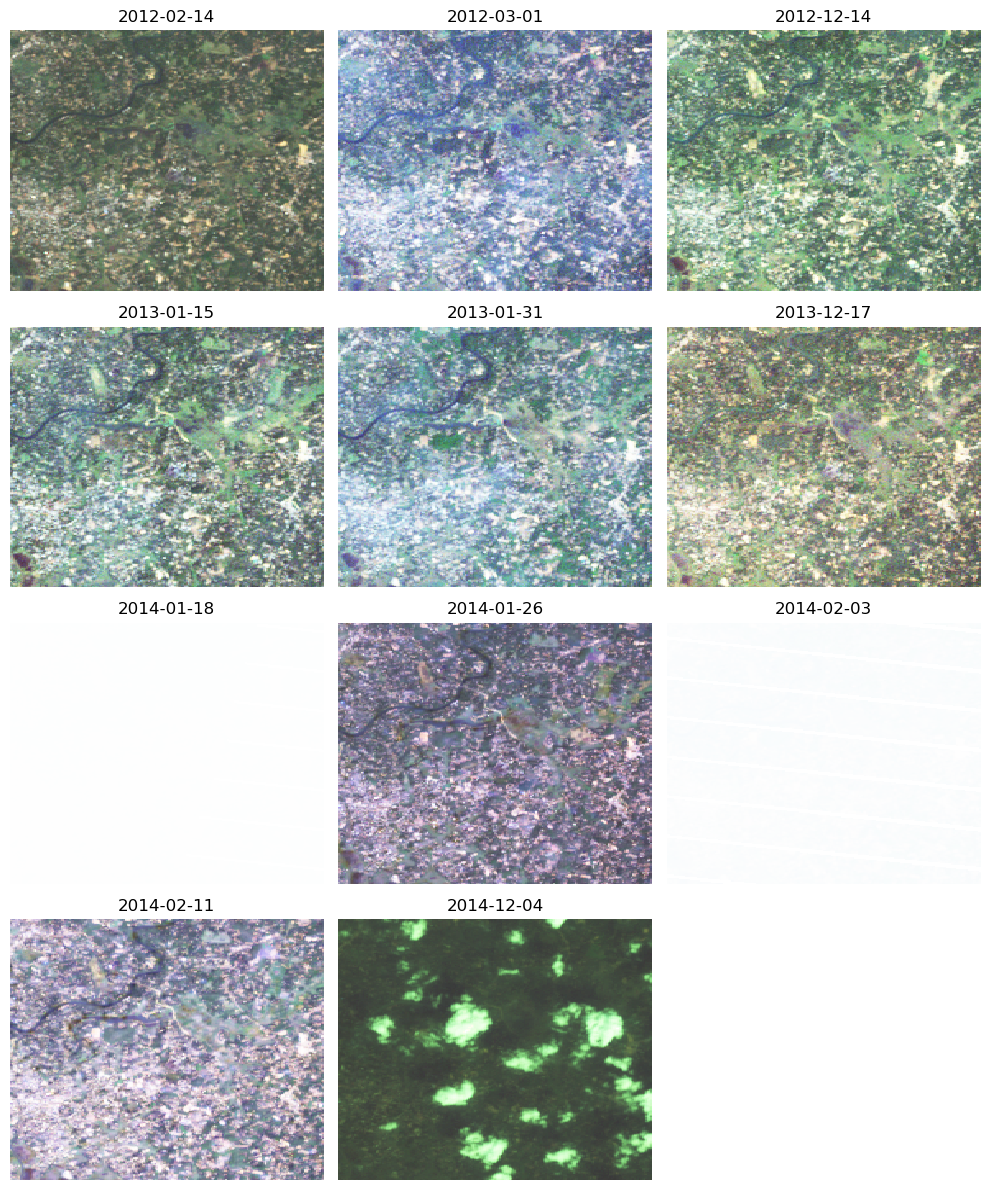

In [61]:
datetime_string = '2012-01-01/2014-12-31'
panchayat_id = 802
bbox = get_bbox(panchayat_id)
max_cloud = 5

create_image_grid(datetime_string, bbox, max_cloud)

In [84]:
# date taken from grid above. If there are two images on the same date, use 1 
	# instead of 0 as sorted_rank to choose the other image

# this provides data for ax4 in plot 

datetime_string = '2012-02-14'
panchayat_id = 802
bbox = get_bbox(panchayat_id)
max_cloud = 5
sorted_rank = 0
crs = "EPSG:4326"
resolution = 0.00027027

upsampled_4326 = upsample_mpc_result(datetime_string, bbox, max_cloud, 
									sorted_rank, crs, resolution)

image_before_upsampled = ms.true_color(	
						r = upsampled_4326[0],
						g = upsampled_4326[1],
						b = upsampled_4326[2]
						)

In [85]:
# vijayaapuram LULC data then and now 

# this is data for ax5 in plot 

state = 'KL'
bbox = bbox_panchayat
period = '2011-12'
save_path = 'vijayapuram_lulc_before.nc'

data_lulc_before = download_lulc_data(state,bbox,period,save_path)

In [86]:
# this is data for ax6 in plot 

data_lulc_after, cmap_lulc, values_to_classes =\
	get_lulc_data_mpc(bbox_panchayat, 2021)

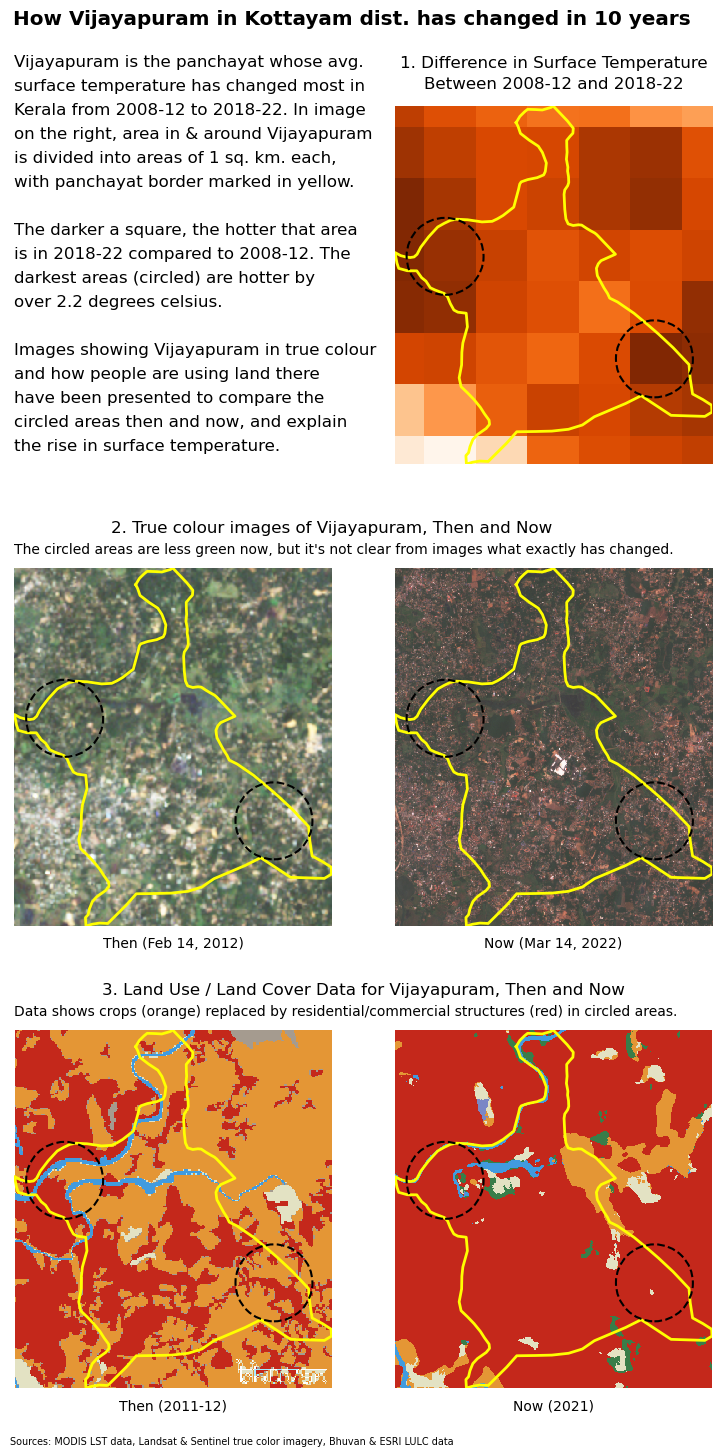

In [87]:
# produces graphic that visualises vijayapuram panchayat 
	# using different forms of satellite data then and now 

%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) =\
	plt.subplots(nrows=3, ncols=2, sharey='row', sharex='col',
	# constrained_layout=True,
	) 

fig.set_size_inches(9, 17)

sup_title =\
	'How Vijayapuram in Kottayam dist. has changed in 10 years'
plt.text(0.5, 0.92, sup_title, transform=fig.transFigure,
		horizontalalignment='center', fontsize='x-large', fontweight='bold')

ax1.set_axis_off()

intro_text = '\n'.join((
	'Vijayapuram is the panchayat whose avg.',
	'surface temperature has changed most in',
	'Kerala from 2008-12 to 2018-22. In image',
	'on the right, area in & around Vijayapuram',
	'is divided into areas of 1 sq. km. each,',
	'with panchayat border marked in yellow.',
	'',
	'The darker a square, the hotter that area',
	'is in 2018-22 compared to 2008-12. The',
	'darkest areas (circled) are hotter by',
	'over 2.2 degrees celsius.',
	'',
	'Images showing Vijayapuram in true colour',
	"and how people are using land there",
	'have been presented to compare the',
	'circled areas then and now, and explain',
	'the rise in surface temperature.'
	))
ax1.text(0, 1.1, intro_text, transform=ax1.transAxes,
		horizontalalignment='left', fontsize='large',linespacing=1.75,
		verticalalignment='top')

#### ax2 -- avg temp diff between before/after around noon

pl_2 = temp_diff['LST_Day_1km_mod'].plot.imshow(ax=ax2, cmap="Oranges")
pl_2.colorbar.remove()
# fig.colorbar(pl_2, ax=ax2, location='bottom', shrink=0.6)

plot_subtitle = "1. Difference in Surface Temperature\n"+\
	'Between 2008-12 and 2018-22'
# plt.title(label = plot_subtitle, pad=0, y=0.8)
plt.text(0.5, 1.05, plot_subtitle, transform=ax2.transAxes,
		horizontalalignment='center', fontsize='large', linespacing=1.5)

# label_heat = 'Difference 2008-12 and 2018-22 avg.'
# ax2.text(0.5, -0.05, label_heat, horizontalalignment='center', 
# 			verticalalignment='center', transform=ax2.transAxes)

#### ax3 -- true color before 

pl_3 = image_before_upsampled.plot.imshow(ax=ax3)


#### ax4 -- true color after 

pl_4 = image_after.plot.imshow(ax=ax4)

plot_subtitle = "2. True colour images of Vijayapuram, Then and Now"
plt.text(1, 1.1, plot_subtitle, transform=ax3.transAxes,
		horizontalalignment='center', fontsize='large')

plot_subtitle = "The circled areas are less green now, but " +\
	"it's not clear from images what exactly has changed."
plt.text(0, 1.04, plot_subtitle, transform=ax3.transAxes,
		horizontalalignment='left', fontsize='medium')

label_list = ['Then (Feb 14, 2012)', 'Now (Mar 14, 2022)']
for ax, label in zip((ax3, ax4), label_list):
	ax.text(0.5, -0.05, label, horizontalalignment='center', 
			verticalalignment='center', transform=ax.transAxes)


#### ax5 -- lulc before 

vmin_lulc = 0
vmax_lulc = max(values_to_classes.keys())

pl_5 = data_lulc_before['class_new_esri'].plot( 
		ax=ax5,
		cmap=cmap_lulc,
		vmin=vmin_lulc,
		vmax=vmax_lulc,
		)

pl_5.colorbar.remove()

# plt_5.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


#### ax6 -- lulc after 

cbar_lulc_labels = [values_to_classes.get(i, "") for i in range(cmap_lulc.N+1)]

pl_6 = data_lulc_after['data'].plot( 
			ax=ax6,
			cmap=cmap_lulc,
			vmin=vmin_lulc,
			vmax=vmax_lulc,
			)
pl_6.colorbar.remove()

plot_subtitle = "3. Land Use / Land Cover Data for Vijayapuram, Then and Now"
plt.text(1.1, 1.1, plot_subtitle, transform=ax5.transAxes,
		horizontalalignment='center', fontsize='large')

plot_subtitle = "Data shows crops (orange) replaced by " +\
	"residential/commercial structures (red) in circled areas."
plt.text(0, 1.04, plot_subtitle, transform=ax5.transAxes,
		horizontalalignment='left', fontsize='medium')

label_list = ['Then (2011-12)', 'Now (2021)']
for ax, label in zip((ax5, ax6), label_list):
	ax.text(0.5, -0.05, label, horizontalalignment='center', 
			verticalalignment='center', transform=ax.transAxes)




# row_3_cbar = fig.colorbar(pl_6, ax=[ax5,ax6], location='bottom',
# 	orientation='horizontal', shrink=0.8)
# ticks_lulc = np.linspace(0, 11, 13)
# row_3_cbar.set_ticks(ticks_lulc, labels=cbar_lulc_labels)
# row_3_cbar.set_label("Class")

# pl_6.colorbar.set_ticks(ticks_lulc, labels=cbar_lulc_labels)
# pl_6.colorbar.set_label("Class")
# pl_6.colorbar(location='bottom', orientation='horizontal')
# pl_6.colorbar.remove()

################

sources_text =\
	'Sources: MODIS LST data, Landsat & Sentinel true color imagery, ' +\
	'Bhuvan & ESRI LULC data'
plt.text(0.12, 0.085, sources_text, transform=fig.transFigure,
		horizontalalignment='left', fontsize='x-small')

######


shapely_polygon = unmerged[unmerged['generated_id']==panchayat_id]\
															['geometry'].iloc[0]
x,y = shapely_polygon.geoms[0].exterior.xy

for ax in (ax2,ax3,ax4,ax5,ax6):

	# pos=ax.get_position()
	# fig.subplots_adjust(right=0.1+pos.width)

	ax.plot(x,y, linewidth=2, color='yellow')
	ax.axes.set_aspect('equal')

	x_min = bbox_panchayat[0]
	y_min = bbox_panchayat[1]
	x_max = bbox_panchayat[2]
	y_max = bbox_panchayat[3]
	ax.set_ylim(ymin = y_min, ymax = y_max)
	ax.set_xlim(xmin = x_min, xmax = x_max)

	e1 = Ellipse((76.54500, 9.60415), 0.0125, 0.0125, linewidth=1.5, 
		facecolor='none', edgecolor='black',linestyle='--' , zorder=2 )
	ax.add_patch(e1)

	e2 = Ellipse((76.57900, 9.5875), 0.0125, 0.0125, linewidth=1.5, 
		facecolor='none', edgecolor='black',linestyle='--' , zorder=2 )
	ax.add_patch(e2)

	ax.set_title('')
	ax.set_axis_off()


# fig.subplots_adjust(top=0.9)
# fig.subplots_adjust(
# 	top=1.1,
# 	# hspace=0.2, 
# 	# wspace=0.01,

# 	)
# fig.tight_layout() # do we need this?

In [88]:
fig.savefig('IMAGES/07_vijayapuram_sat_data.png', bbox_inches='tight', dpi=100)

Text(0, -0.03, 'Source: OpenStreetMap')

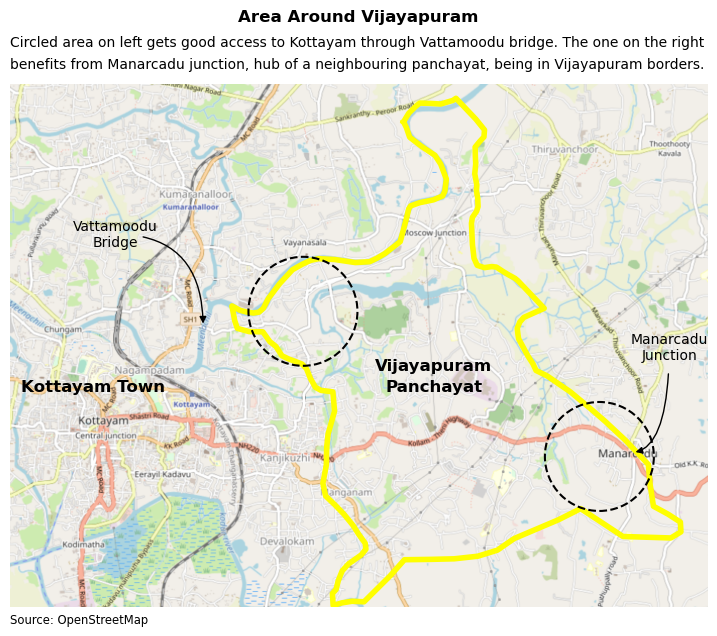

In [45]:
# this cell produces a graphic that uses openstreetmap data and shows immediate 
	# surroundings of vijayapuram panchayat 

%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

#https://www.openstreetmap.org/relation/11482050#map=14/9.6002/76.5564&layers=T

fig, ax = plt.subplots(figsize=(9,9))
ax.set_axis_off()

centroid = [76.5564, 9.6002] # from trial & error on openstreetmap.org

x_min = centroid[0] - 0.045
y_min = centroid[1] - 0.03
x_max = centroid[0] + 0.035
y_max = centroid[1] + 0.03
ax.set_ylim(ymin = y_min, ymax = y_max)
ax.set_xlim(xmin = x_min, xmax = x_max)

ctx.add_basemap(ax, crs=unmerged.crs.to_string(),
				source=ctx.providers.OpenStreetMap.Mapnik,
				zoom=14,
				reset_extent=True,
				attribution = '',
				)

#vijayapuram in kottayam 802 
panchayat_id = 802
shapely_polygon = unmerged[unmerged['generated_id']==panchayat_id]\
															['geometry'].iloc[0]
x,y = shapely_polygon.geoms[0].exterior.xy
ax.plot(x,y, linewidth=4, color='yellow')

ax.axes.set_aspect('equal')

e1 = Ellipse((76.54500, 9.60415), 0.0125, 0.0125, linewidth=1.5, 
	facecolor='none', edgecolor='black',linestyle='--', zorder=2 )
ax.add_patch(e1)

e2 = Ellipse((76.57900, 9.5875), 0.0125, 0.0125, linewidth=1.5, 
	facecolor='none', edgecolor='black',linestyle='--', zorder=2 )
ax.add_patch(e2)

kott_text='Kottayam Town'
ax.text(s=kott_text,horizontalalignment='left', fontweight='bold', 
	x=76.5127,y=9.595,linespacing=1.5, fontsize='large')

panch_text = 'Vijayapuram\nPanchayat'
ax.text(s=panch_text,
	horizontalalignment='center', fontweight='bold', x=76.56,y=9.595,
	linespacing=1.5, fontsize='large')

ax.annotate("Manarcadu\nJunction",	xy=(76.58235, 9.58791), 
		xycoords='data', xytext=(76.587, 9.6), va="center", ha="center", textcoords='data', arrowprops=dict(arrowstyle="-|>", color="0", shrinkA=19, shrinkB=5, patchA=None, patchB=None, 
		connectionstyle="angle3,angleA=90,angleB=0",))


ax.annotate("Vattamoodu\nBridge", xy=(76.53354771883434, 9.6022633364789), 
		xycoords='data', xytext=(76.5235, 9.613), va="center", ha="center", textcoords='data', arrowprops=dict(arrowstyle="-|>", color="0", shrinkA=20, shrinkB=3, patchA=None, patchB=None, 
		connectionstyle="angle3,angleA=0,angleB=90",))

title_text = 'Area Around Vijayapuram'
ax.text(s=title_text,
	horizontalalignment='center', fontweight='bold', x=0.5,y=1.12,
	linespacing=1.5, fontsize='large',transform=ax.transAxes)

intro_text = 'Circled area on left gets good access to Kottayam through Vattamoodu bridge. The one on the right\n' +\
	'benefits from Manarcadu junction, hub of a neighbouring panchayat, being in Vijayapuram borders.'
ax.text(s=intro_text,
	horizontalalignment='left', fontweight='normal', x=0,y=1.03,
	linespacing=1.7, fontsize='medium',transform=ax.transAxes)

source_text = 'Source: OpenStreetMap'
ax.text(s=source_text,
	horizontalalignment='left', fontweight='normal', x=0,y=-0.03,
	linespacing=1.5, fontsize='small',transform=ax.transAxes)


In [46]:
fig.savefig('IMAGES/08_vijayapuram_surroundings.png', bbox_inches='tight', dpi=100)